In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

In [3]:
from scAAnet.tools import load_df_from_npz, save_df_to_npz, plotRankedGeneScore, plotDensity, plotDensityGamma, geneScore

# Load data to adata

In [3]:
adata = sc.read_mtx('/ysm-gpfs/pi/zhao/yw599/jupyter/ROSMAP_data/Mathy2019/filtered_count_matrix.mtx')

In [5]:
adata = adata.transpose()

In [88]:
genes = pd.read_csv('/ysm-gpfs/pi/zhao/yw599/jupyter/ROSMAP_data/Mathy2019/filtered_gene_row_names.txt', 
                    sep='\n',header=None, index_col=0) 

In [93]:
genes.index.name = None

In [65]:
cellinfo = pd.read_csv('/ysm-gpfs/pi/zhao/yw599/jupyter/ROSMAP_data/Mathy2019/filtered_column_metadata.txt', 
                       sep='\t', index_col=0)

In [95]:
adata = sc.AnnData(adata.X, obs=cellinfo, var=genes)

In [67]:
adata

AnnData object with n_obs × n_vars = 70634 × 17926
    obs: 'projid', 'tsne1', 'tsne2', 'pre.cluster', 'broad.cell.type', 'Subcluster'

In [92]:
adata.obs['pre.cluster'] = adata.obs['pre.cluster'].astype('category')
adata.obs['projid'] = adata.obs['projid'].astype('category')
adata.obs['n_counts'] = adata.obs['n_counts'].astype('int64')

In [30]:
adata.obs['n_counts'] = adata.X.sum(1)

In [ ]:
adata.obsm['X_tsne'] = np.array(adata.obs[['tsne1','tsne2']])

In [ ]:
# Add clinical and pathological and demographical data

In [ ]:
clinical = pd.read_csv('/ysm-gpfs/pi/zhao/yw599/jupyter/ROSMAP_data/Mathy2019/ROSMAP_clinical.csv')

In [10]:
mapping = pd.read_csv('/ysm-gpfs/pi/zhao/yw599/jupyter/ROSMAP_data/Mathy2019/snRNAseqPFC_BA10_id_mapping.csv')
mapping = mapping.drop(columns=['fastq'])
mapping = mapping.drop_duplicates()

In [12]:
metadata = pd.read_csv('/ysm-gpfs/pi/zhao/yw599/jupyter/ROSMAP_data/Mathy2019/clinical_patho_demo.csv')

In [35]:
result = pd.merge(metadata, mapping, how='left', on='Subject')

In [58]:
obs = pd.merge(adata.obs, result, how='left', on='projid')
obs.index = adata.obs.index
adata.obs = obs

In [94]:
adata.write('/ysm-gpfs/pi/zhao/yw599/jupyter/ROSMAP_data/Mathy2019/snRNAseqPFC_BA10.h5ad')

# Data Exploration

In [4]:
adata = sc.read_h5ad('/ysm-gpfs/pi/zhao/yw599/jupyter/ROSMAP_data/Mathy2019/snRNAseqPFC_BA10.h5ad')

In [100]:
adata.obs['broad.cell.type'].value_counts()

Ex     34976
Oli    18235
In      9196
Ast     3392
Opc     2627
Mic     1920
Per      167
End      121
Name: broad.cell.type, dtype: int64

In [90]:
pd.crosstab(adata.obs['AD'],adata.obs['msex'])

msex  male  female
AD                
No     577     388
Yes    320     635

In [93]:
from scipy.stats import chi2_contingency
chi2_contingency(pd.crosstab(adata.obs['AD'],adata.obs['msex']))

(132.16824267574745,
 1.3746156855981118e-30,
 1,
 array([[450.8359375, 514.1640625],
        [446.1640625, 508.8359375]]))

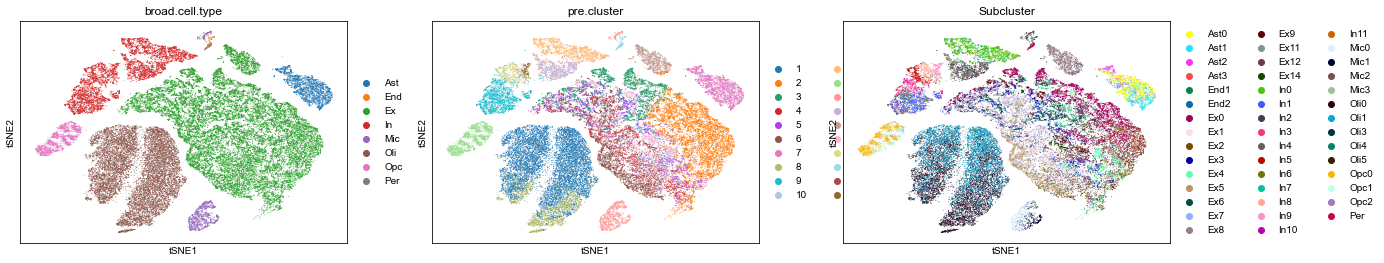

In [72]:
sc.pl.tsne(adata, color=['broad.cell.type','pre.cluster','Subcluster'])

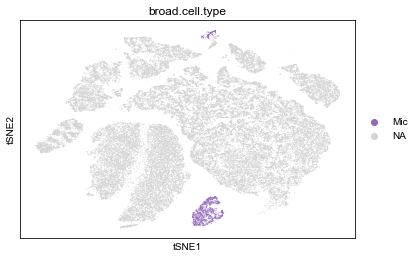

In [27]:
sc.pl.tsne(adata, color=['broad.cell.type'], groups='Mic')

# Get a subset of microglia cells

In [97]:
adata_mic = adata[adata.obs['broad.cell.type'] == 'Mic']

In [13]:
adata_mic.obs.Subcluster.value_counts()

Mic0    1141
Mic1     509
Mic2     169
Mic3     101
Name: Subcluster, dtype: int64

In [75]:
adata_mic_original = adata_mic.copy()

/ysm-gpfs/pi/zhao/yw599/conda_envs/scvi/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


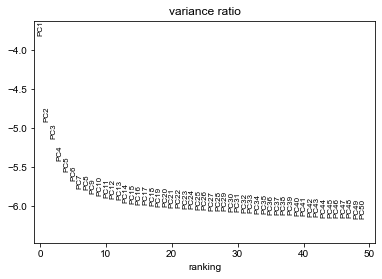

In [78]:
sc.pp.normalize_total(adata_mic, target_sum=1e4)
sc.pp.log1p(adata_mic)
sc.pp.highly_variable_genes(adata_mic, n_top_genes=2000)
adata_mic.raw = adata_mic
sc.pp.regress_out(adata_mic, ['n_counts'])
sc.pp.scale(adata_mic, max_value=10)
sc.tl.pca(adata_mic, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_mic, log=True, n_pcs=50)

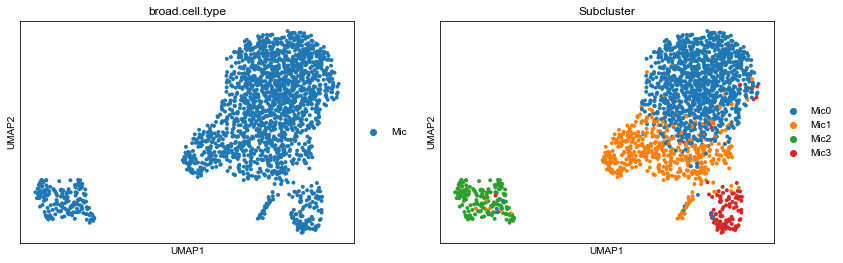

In [80]:
sc.pp.neighbors(adata_mic, n_pcs=10, n_neighbors=15)
sc.tl.umap(adata_mic)
# n_pcs=10, n_neighbors=15
sc.pl.umap(adata_mic, color=['Subcluster'])

In [84]:
# Append X_umap to adata_original
adata_mic_original.obsm['X_umap'] = adata_mic.obsm['X_umap']

In [107]:
# Save to h5ad file
adata_mic_original.write('/ysm-gpfs/pi/zhao/yw599/jupyter/ROSMAP_data/Mathy2019/mic_all.h5ad')

In [88]:
# Get a subset based on hvgs
hvg = adata_mic.var.index[adata_mic.var["highly_variable"]].tolist()
adata_mic_original = adata_mic_original[:, hvg]

/ysm-gpfs/pi/zhao/yw599/conda_envs/scvi/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [113]:
# Save to h5ad file
adata_mic_original.write('/ysm-gpfs/pi/zhao/yw599/jupyter/ROSMAP_data/Mathy2019/mic.h5ad')

# Run NMF

In [45]:
adata = sc.read_h5ad('/ysm-gpfs/pi/zhao/yw599/jupyter/ROSMAP_data/Mathy2019/mic.h5ad')
X_umap = adata.obsm['X_umap']

In [54]:
adata

AnnData object with n_obs × n_vars = 1920 × 2000
    obs: 'projid', 'tsne1', 'tsne2', 'pre.cluster', 'broad.cell.type', 'Subcluster', 'n_counts', 'Subject', 'age_death', 'educ', 'msex', 'amyloid', 'plaq_n', 'nft', 'tangles', 'cogn_global_lv', 'gpath', 'gpath_3neocort', 'amyloid.group', 'caa_4gp', 'ceradsc', 'braaksc', 'niareagansc', 'cogdx', 'pathology.group', 'AD'
    uns: 'Subcluster_colors', 'pre.cluster_colors', 'projid_colors'
    obsm: 'X_tsne', 'X_umap'

In [53]:
count = pd.DataFrame(adata.X.todense(), index=adata.obs.index, columns=adata.var.index)
print(count.shape[0])
tpm = count.div(count.sum(axis=1), axis=0)

1920


In [55]:
from sklearn.decomposition import non_negative_factorization

In [56]:
K = 4
seed=1
nmf_kwargs = dict(
    alpha=0.0,
    l1_ratio=0.0,
    beta_loss='frobenius',
    solver='cd',
    tol=1e-4,
    max_iter=400,
    regularization=None,
    init='random',
    random_state=seed,
    n_components=K)
(W, H, niter) = non_negative_factorization(tpm, **nmf_kwargs)
recon = np.matmul(W, H)

In [57]:
usage = pd.DataFrame(W, index=count.index, columns = np.arange(1,K+1))
usage = usage.div(usage.sum(axis=1), axis=0)
spectra = pd.DataFrame(np.transpose(H), index=count.columns, columns=np.arange(1,K+1))
recon = pd.DataFrame(recon, index=count.index, columns=count.columns)

In [10]:
dist = 'nmf'

In [59]:
save_df_to_npz(spectra, '/home/yw599/project/mathy_data/mathy_mic.program.%s.rs%d.k%s.df.npz'%(dist, seed, K))
save_df_to_npz(usage, '/home/yw599/project/mathy_data/mathy_mic.usage.%s.rs%d.k%s.df.npz'%(dist, seed, K))
save_df_to_npz(recon, '/home/yw599/project/mathy_data/mathy_mic.recon.%s.rs%d.k%s.df.npz'%(dist, seed, K))

/gpfs/ysm/home/yw599/venv/lib64/python3.6/site-packages/numpy/lib/format.py:356: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [11]:
spectra = load_df_from_npz('/home/yw599/project/mathy_data/mathy_mic.program.%s.rs%d.k%s.df.npz'%(dist, seed, K))
usage = load_df_from_npz('/home/yw599/project/mathy_data/mathy_mic.usage.%s.rs%d.k%s.df.npz'%(dist, seed, K))
recon = load_df_from_npz('/home/yw599/project/mathy_data/mathy_mic.recon.%s.rs%d.k%s.df.npz'%(dist, seed, K))

In [12]:
for i in range(usage.shape[1]):
    adata.obs["GEP %s"%(i+1)] = usage.iloc[:,i]
arch_loc = usage.to_numpy().argmax(0)

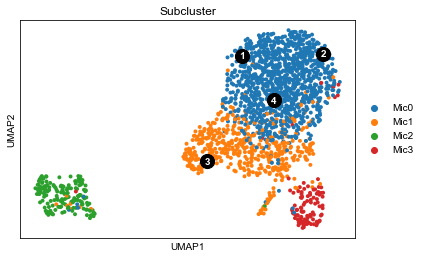

In [17]:
(fig, ax) = plt.subplots(1,1)
for num,i in enumerate(arch_loc):
    ax.scatter(X_umap[i,0], X_umap[i,1], s=200, c='k', zorder=3)
    ax.text(X_umap[i,0], X_umap[i,1], num+1, horizontalalignment='center', verticalalignment='center', 
            fontdict={'color':'white','size':10,'weight':'bold'}, zorder=4)
sc.pl.umap(adata, color="Subcluster", ax=ax, save='_mic_nmf_subcluster.pdf')

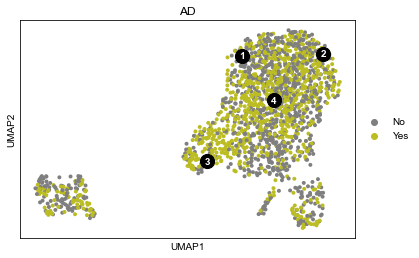

In [66]:
lut2 = {'No': '#7f7f7f', 'Yes': '#bcbd22'}
(fig, ax) = plt.subplots(1,1)
for num,i in enumerate(arch_loc):
    ax.scatter(X_umap[i,0], X_umap[i,1], s=200, c='k', zorder=3)
    ax.text(X_umap[i,0], X_umap[i,1], num+1, horizontalalignment='center', verticalalignment='center', 
            fontdict={'color':'white','size':10,'weight':'bold'}, zorder=4)
sc.pl.umap(adata, color="AD", ax=ax, title='AD', palette=lut2, save='_AD.pdf')

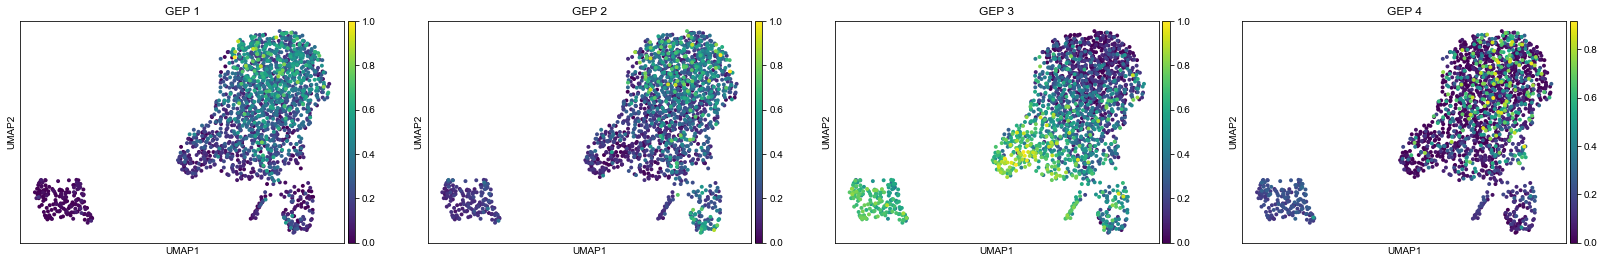

In [18]:
sc.pl.umap(adata, color=["GEP %s"%(i+1) for i in range(usage.shape[1])], save='_mic_nmf_usage.pdf')

# Run scAAnet

In [ ]:
from scAAnet.api import scAAnet

In [6]:
adata = sc.read_h5ad('/ysm-gpfs/pi/zhao/yw599/jupyter/ROSMAP_data/Mathy2019/mic.h5ad')
X_umap = adata.obsm['X_umap']

In [7]:
dist = 'P'
rs = 3
K = 4
batch_size = 64
hid_size = 128

In [ ]:
preds, losses = scAAnet(adata, dispersion='gene-cell',
                             hidden_size=(hid_size, K, hid_size), ae_type='poisson',
                             epochs=epochs, batch_size=batch_size,
                             early_stop=100, reduce_lr=10, learning_rate=0.01, 
                             warm_up=20, random_state=rs, return_loss=True)

In [8]:
spectra = load_df_from_npz('/home/yw599/project/mathy_data/mathy_mic.program.wu20.%s.rs%d.k%s.df.npz'%(dist, rs, K))
usage = load_df_from_npz('/home/yw599/project/mathy_data/mathy_mic.usage.wu20.%s.rs%d.k%s.df.npz'%(dist, rs, K))
recon = load_df_from_npz('/home/yw599/project/mathy_data/mathy_mic.recon.wu20.%s.rs%d.k%s.df.npz'%(dist, rs, K))

## Assess the sparsity of inferred usage through minimum usage

In [22]:
adata.obs['min_usage'] = usage.min(1)
adata.obs["min_range"] = pd.cut(adata.obs['min_usage'], bins=[0,0.01,0.02,0.05,0.1,1.], right=False)
df = adata.obs.groupby(["min_range", "Subcluster"]).size().to_frame()
df.reset_index(inplace=True)
df = df.rename(columns={0:'count'})
df['per'] = df['count']
temp = df.groupby(["Subcluster"]).sum()['count']
for c in temp.index:
    df.loc[df['Subcluster'] == c,'per'] = df[df['Subcluster'] == c]['per']/temp[c]

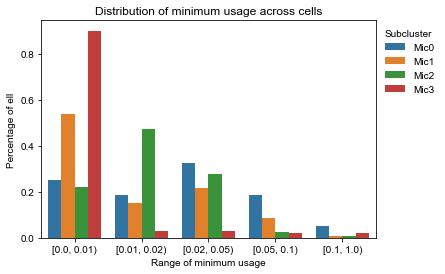

In [24]:
g = sns.barplot(x='min_range',y='per',hue='Subcluster', data=df)
g.set_ylabel('Percentage of ell')
g.set_xlabel('Range of minimum usage')
g.set_title('Distribution of minimum usage across cells')
handles, labels = g.get_legend_handles_labels()
leg = g.legend(handles, labels, 
             bbox_to_anchor=(1, 1), loc=2, title='Subcluster', frameon=False)
leg._legend_box.align = "left"

## Assess the sharing of GEPs through maximum usage

In [25]:
adata.obs['max_usage'] = usage.max(1)
adata.obs["max_range"] = pd.cut(adata.obs['max_usage'], bins=[0,0.2,0.4,0.6,0.8,1.], right=False)
df = adata.obs.groupby(["max_range", "Subcluster"]).size().to_frame()
df.reset_index(inplace=True)
df = df.rename(columns={0:'count'})
df['per'] = df['count']
temp = df.groupby(["Subcluster"]).sum()['count']
for c in temp.index:
    df.loc[df['Subcluster'] == c,'per'] = df[df['Subcluster'] == c]['per']/temp[c]

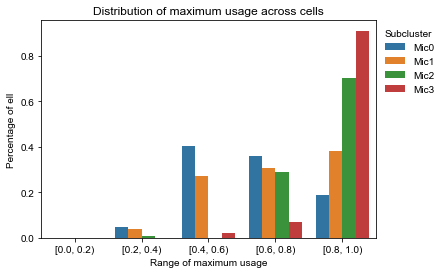

In [27]:
g = sns.barplot(x='max_range',y='per',hue='Subcluster', data=df)
g.set_ylabel('Percentage of ell')
g.set_xlabel('Range of maximum usage')
g.set_title('Distribution of maximum usage across cells')
handles, labels = g.get_legend_handles_labels()
leg = g.legend(handles, labels, 
             bbox_to_anchor=(1, 1), loc=2, title='Subcluster', frameon=False)
leg._legend_box.align = "left"

## MDS visualization of archetypal space

In [28]:
from sklearn.manifold import MDS

In [29]:
data_at = usage.to_numpy()
embedding = MDS(n_components=2)
Y_mds_ats = embedding.fit_transform(np.transpose(spectra))
Y_mds_data = data_at @ Y_mds_ats

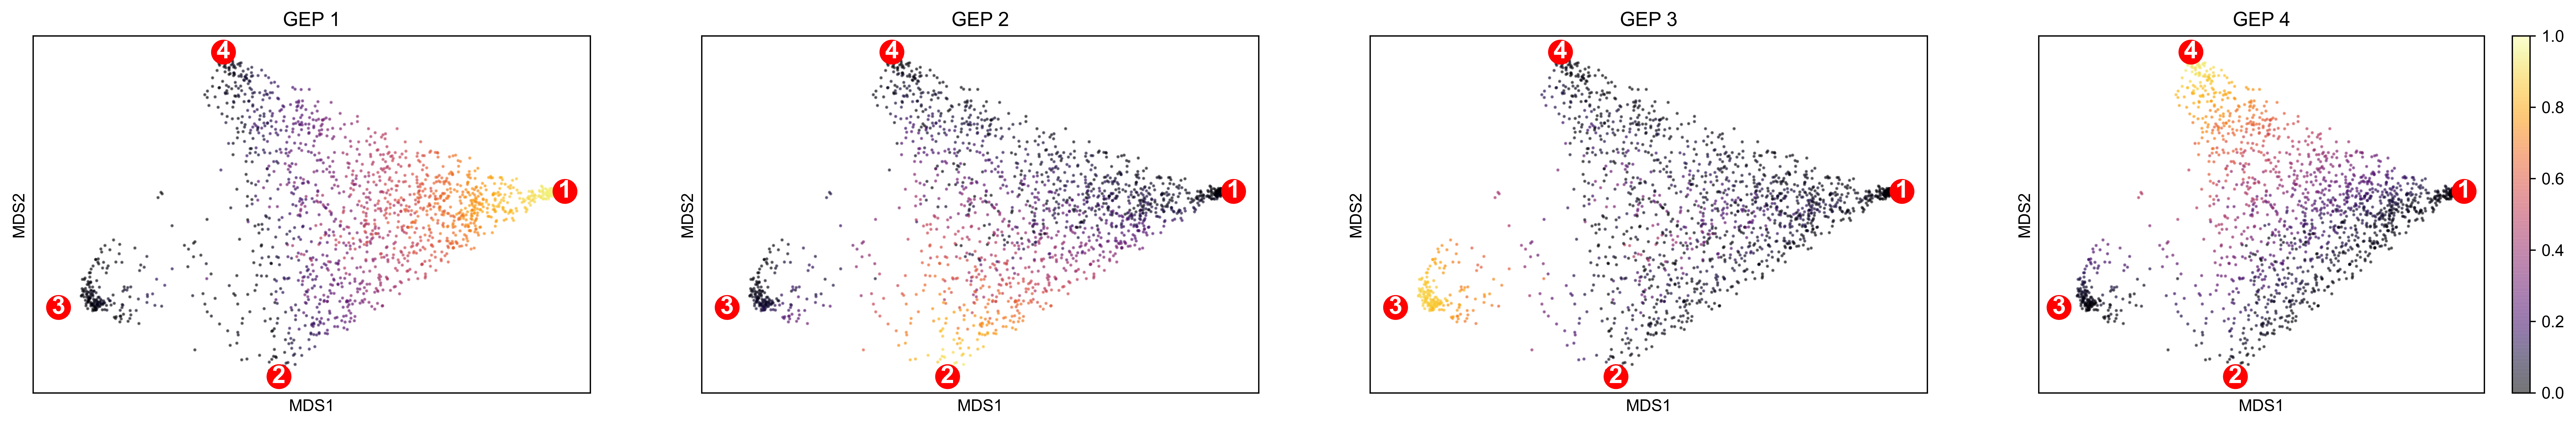

In [32]:
(fig, ax) = plt.subplots(1,K,figsize=(7*K, 4), dpi=600)
plt.suptitle('')
for i in range(K):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel('MDS1')
    ax[i].set_ylabel('MDS2')
    g = ax[i].scatter(Y_mds_data[:,0], Y_mds_data[:,1], s=1, alpha=0.5,
               cmap='inferno', c=usage.iloc[:, i], vmin=0, vmax=1)
    ax[i].set_title('GEP %d' % (i+1))
    ax[i].scatter(Y_mds_ats[:,0], Y_mds_ats[:,1], s=200, c='r', zorder=3)
    for k in range(Y_mds_ats.shape[0]):
        ax[i].text(Y_mds_ats[k,0], Y_mds_ats[k,1], k+1, horizontalalignment='center', verticalalignment='center', 
                   fontdict={'color': 'white','size':15,'weight':'bold'}, zorder=4)

In [33]:
adata.obsm['X_umap'] = Y_mds_data

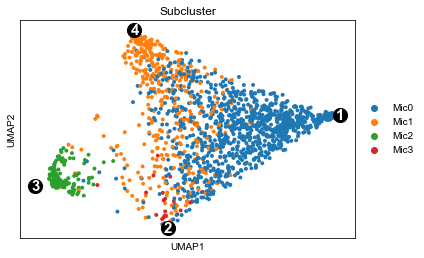

In [34]:
(fig, ax) = plt.subplots(1,1)
for i in range(K):
    ax.scatter(Y_mds_ats[i,0], Y_mds_ats[i,1], s=200, c='k', zorder=3)
    ax.text(Y_mds_ats[i,0], Y_mds_ats[i,1], i+1, horizontalalignment='center', verticalalignment='center', 
            fontdict={'color':'white','size':15,'weight':'bold'}, zorder=4)
sc.pl.umap(adata, color="Subcluster", ax=ax, save='_mic_MDS_subcluster.pdf')

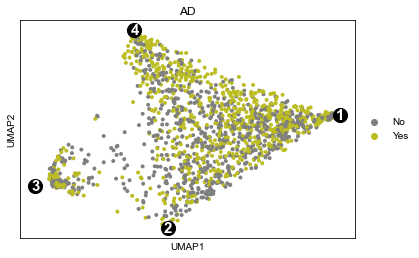

In [35]:
lut2 = {'No': '#7f7f7f', 'Yes': '#bcbd22'}
(fig, ax) = plt.subplots(1,1)
for i in range(K):
    ax.scatter(Y_mds_ats[i,0], Y_mds_ats[i,1], s=200, c='k', zorder=3)
    ax.text(Y_mds_ats[i,0], Y_mds_ats[i,1], i+1, horizontalalignment='center', verticalalignment='center', 
            fontdict={'color':'white','size':15,'weight':'bold'}, zorder=4)
sc.pl.umap(adata, color="AD", ax=ax, title='AD', palette=lut2, save='_mic_MDS_AD.pdf')

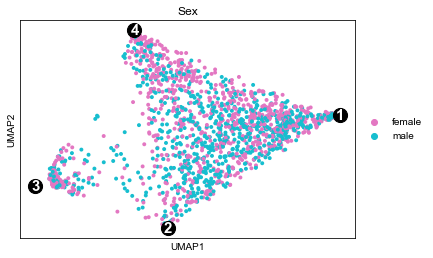

In [36]:
lut2 = {'male': '#17becf', 'female': '#e377c2'}
(fig, ax) = plt.subplots(1,1)
for i in range(K):
    ax.scatter(Y_mds_ats[i,0], Y_mds_ats[i,1], s=200, c='k', zorder=3)
    ax.text(Y_mds_ats[i,0], Y_mds_ats[i,1], i+1, horizontalalignment='center', verticalalignment='center', 
            fontdict={'color':'white','size':15,'weight':'bold'}, zorder=4)
sc.pl.umap(adata, color="msex", ax=ax, title='Sex', palette=lut2, save='_mic_MDS_sex.pdf')

## UMAP visualization

In [9]:
for i in range(usage.shape[1]):
    adata.obs["GEP %s"%(i+1)] = usage.iloc[:,i]
arch_loc = usage.to_numpy().argmax(0)

In [10]:
arch_loc

array([1877,   85, 1505,  906])

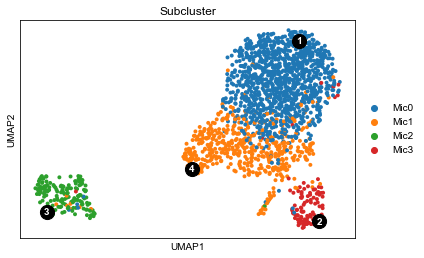

In [11]:
(fig, ax) = plt.subplots(1,1)
for num,i in enumerate(arch_loc):
    ax.scatter(X_umap[i,0], X_umap[i,1], s=200, c='k', zorder=3)
    ax.text(X_umap[i,0], X_umap[i,1], num+1, horizontalalignment='center', verticalalignment='center', 
            fontdict={'color':'white','size':10,'weight':'bold'}, zorder=4)
sc.pl.umap(adata, color="Subcluster", ax=ax, save='_subcluster.pdf')

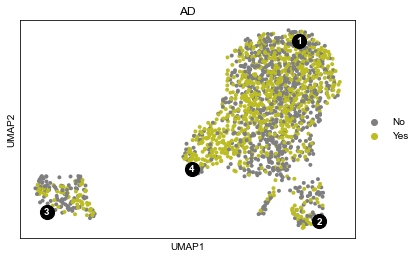

In [13]:
lut2 = {'No': '#7f7f7f', 'Yes': '#bcbd22'}
(fig, ax) = plt.subplots(1,1)
for num,i in enumerate(arch_loc):
    ax.scatter(X_umap[i,0], X_umap[i,1], s=200, c='k', zorder=3)
    ax.text(X_umap[i,0], X_umap[i,1], num+1, horizontalalignment='center', verticalalignment='center', 
            fontdict={'color':'white','size':10,'weight':'bold'}, zorder=4)
sc.pl.umap(adata, color="AD", ax=ax, title='AD', palette=lut2, save='_AD.pdf')

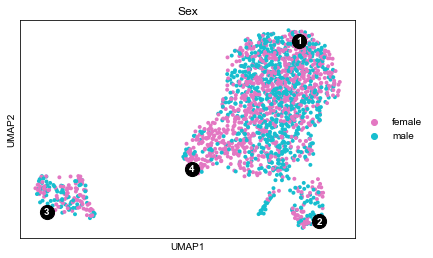

In [14]:
lut2 = {'male': '#17becf', 'female': '#e377c2'}
(fig, ax) = plt.subplots(1,1)
for num,i in enumerate(arch_loc):
    ax.scatter(X_umap[i,0], X_umap[i,1], s=200, c='k', zorder=3)
    ax.text(X_umap[i,0], X_umap[i,1], num+1, horizontalalignment='center', verticalalignment='center', 
            fontdict={'color':'white','size':10,'weight':'bold'}, zorder=4)
sc.pl.umap(adata, color="msex", ax=ax, title='Sex', palette=lut2, save='_sex.pdf')

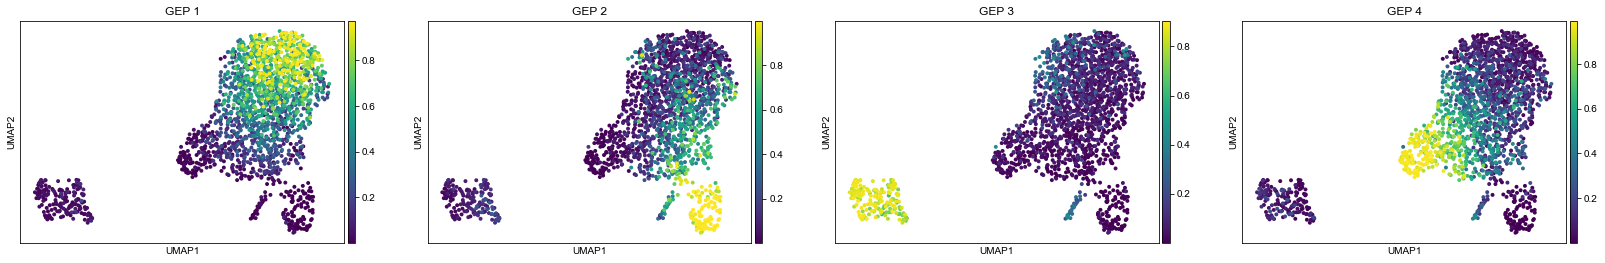

In [16]:
sc.pl.umap(adata, color=["GEP %s"%(i+1) for i in range(usage.shape[1])], save='_usage.pdf')

# Various plots

In [9]:
gep_order = [1,2,3,4]
usage_sorted = usage.loc[:,gep_order]
usage_sorted.columns = ['GEP %d'%i for i in usage_sorted.columns]

[None, None, None, None, None, None, None, None]

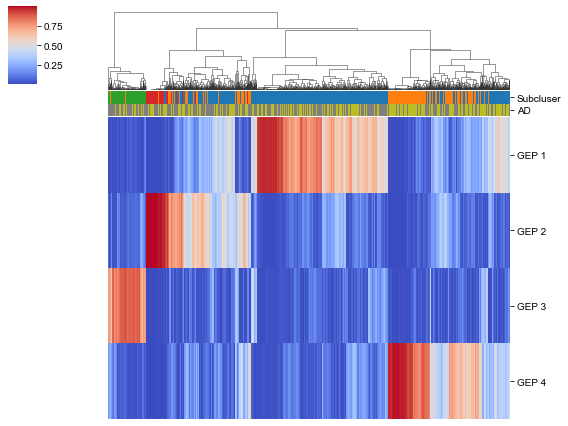

In [401]:
# Heatmap of cell usage matrix
lut1 = dict(zip(adata.obs["Subcluster"].cat.categories, adata.uns['Subcluster_colors']))
col_colors1 = adata.obs['Subcluster'].map(lut).rename('Subcluser')
lut2 = {'No': '#7f7f7f', 'Yes': '#bcbd22'}
col_colors2 = adata.obs['AD'].map(lut2).rename('AD')
# lut3 = {'no-pathology': '#7f7f7f', 'early-pathology': '#bcbd22', 'late-pathology': '#17becf'}
# col_colors3 = adata.obs['pathology.group'].map(lut3).rename('Pathology group')
col_colors = pd.concat([col_colors1, col_colors2],axis=1)
cmap = sns.color_palette("coolwarm", as_cmap=True)
cg = sns.clustermap(usage_sorted.transpose(), xticklabels=False, figsize=(8,6),
               row_cluster=False, col_cluster=True, col_colors=col_colors, cmap=cmap)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.savefig('/ysm-gpfs/pi/zhao/yw599/scAAnet/figures/cell_usage_heatmap.pdf')
# plt.close()

In [30]:
ct_order = ['Mic0', 'Mic1', 'Mic2', 'Mic3']
cmap = sns.color_palette("rocket_r", as_cmap=True)

[None, None, None, None, None, None, None, None]

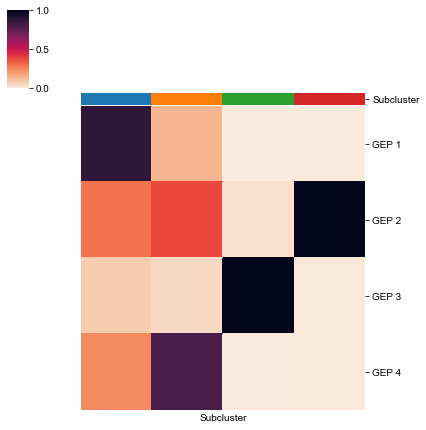

In [33]:
# % Cells With GEP Usage > 25% by Published Cluster
percent_group_usage = usage.groupby(adata.obs["Subcluster"], axis=0).apply(lambda x: (x>.25).mean())
percent_group_usage = percent_group_usage.loc[:,gep_order]
percent_group_usage.columns = ['GEP %d'%i for i in percent_group_usage.columns]
percent_group_usage = percent_group_usage.loc[ct_order]
lut = dict(zip(adata.obs["Subcluster"].cat.categories, adata.uns['Subcluster_colors']))
col_colors = percent_group_usage.index.map(lut).rename('Subcluster')
col_colors = pd.DataFrame(col_colors, index=ct_order)
cg = sns.clustermap(percent_group_usage.transpose(), xticklabels=False, figsize=(6,6),
               row_cluster=False, col_cluster=False, col_colors=col_colors, cmap=cmap)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

In [12]:
cmap = sns.color_palette("rocket_r", as_cmap=True)

                   GEP 1     GEP 2     GEP 3     GEP 4
Subcluster AD                                         
Mic0       No   0.861456  0.330373  0.097691  0.195382
           Yes  0.882353  0.262976  0.069204  0.290657
Mic1       No   0.163866  0.588235  0.075630  0.705882
           Yes  0.121771  0.195572  0.022140  0.896679
Mic2       No   0.000000  0.028037  1.000000  0.009346
           Yes  0.000000  0.032258  1.000000  0.000000
Mic3       No   0.000000  1.000000  0.000000  0.000000
           Yes  0.000000  1.000000  0.022727  0.022727


[None, None, None, None, None, None, None, None]

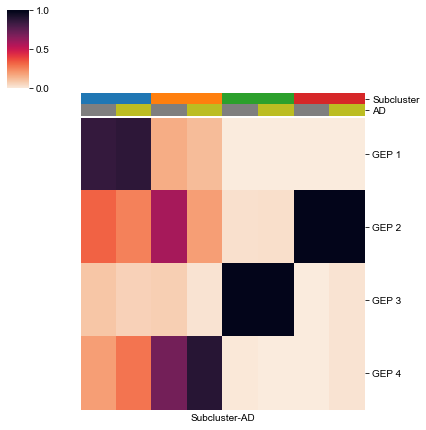

In [13]:
# % Cells With GEP Usage > 25% by Published Cluster
percent_group_usage = usage.groupby([adata.obs["Subcluster"], adata.obs["AD"]], axis=0).apply(lambda x: (x>.25).mean())
percent_group_usage = percent_group_usage.loc[:,gep_order]
percent_group_usage.columns = ['GEP %d'%i for i in percent_group_usage.columns]
print(percent_group_usage)
# percent_group_usage = percent_group_usage.loc[ct_order]
lut1 = dict(zip(adata.obs["Subcluster"].cat.categories, adata.uns['Subcluster_colors']))
col_colors1 = percent_group_usage.index.get_level_values('Subcluster').map(lut1).rename('Subcluster')
lut2 = {'No': '#7f7f7f', 'Yes': '#bcbd22'}
col_colors2 = percent_group_usage.index.get_level_values('AD').map(lut2).rename('AD')
col_colors = pd.DataFrame({'Subcluster': col_colors1.values, 'AD': col_colors2.values}, index=percent_group_usage.index)
cg = sns.clustermap(percent_group_usage.transpose(), xticklabels=False, figsize=(6,6),
               row_cluster=False, col_cluster=False, col_colors=col_colors, cmap=cmap)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)


In [14]:
adata.obs.msex = adata.obs.msex.cat.reorder_categories(['male', 'female'])

                      GEP 1     GEP 2     GEP 3     GEP 4
Subcluster msex                                          
Mic0       male    0.859402  0.326889  0.107206  0.223199
           female  0.884615  0.265734  0.059441  0.263986
Mic1       male    0.154639  0.582474  0.072165  0.706186
           female  0.133333  0.253968  0.031746  0.869841
Mic2       male    0.000000  0.024691  1.000000  0.012346
           female  0.000000  0.034091  1.000000  0.000000
Mic3       male    0.000000  1.000000  0.000000  0.018868
           female  0.000000  1.000000  0.020833  0.000000


[None, None, None, None, None, None, None, None]

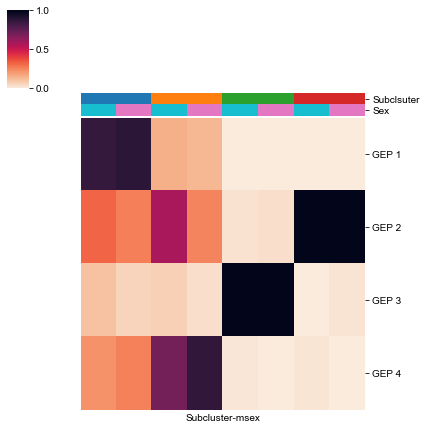

In [15]:
# % Cells With GEP Usage > 25% by Published Cluster
percent_group_usage = usage.groupby([adata.obs["Subcluster"], adata.obs["msex"]], axis=0).apply(lambda x: (x>.25).mean())
percent_group_usage = percent_group_usage.loc[:,gep_order]
percent_group_usage.columns = ['GEP %d'%i for i in percent_group_usage.columns]
print(percent_group_usage)
# percent_group_usage = percent_group_usage.loc[ct_order]
lut1 = dict(zip(adata.obs["Subcluster"].cat.categories, adata.uns['Subcluster_colors']))
col_colors1 = percent_group_usage.index.get_level_values('Subcluster').map(lut1).rename('Subcluster')
lut2 = {'male': '#17becf', 'female': '#e377c2'}
col_colors2 = percent_group_usage.index.get_level_values('msex').map(lut2).rename('Sex')
col_colors = pd.DataFrame({'Subclsuter': col_colors1.values, 'Sex': col_colors2.values}, index=percent_group_usage.index)
cg = sns.clustermap(percent_group_usage.transpose(), xticklabels=False, figsize=(6,6),
               row_cluster=False, col_cluster=False, col_colors=col_colors, cmap=cmap)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

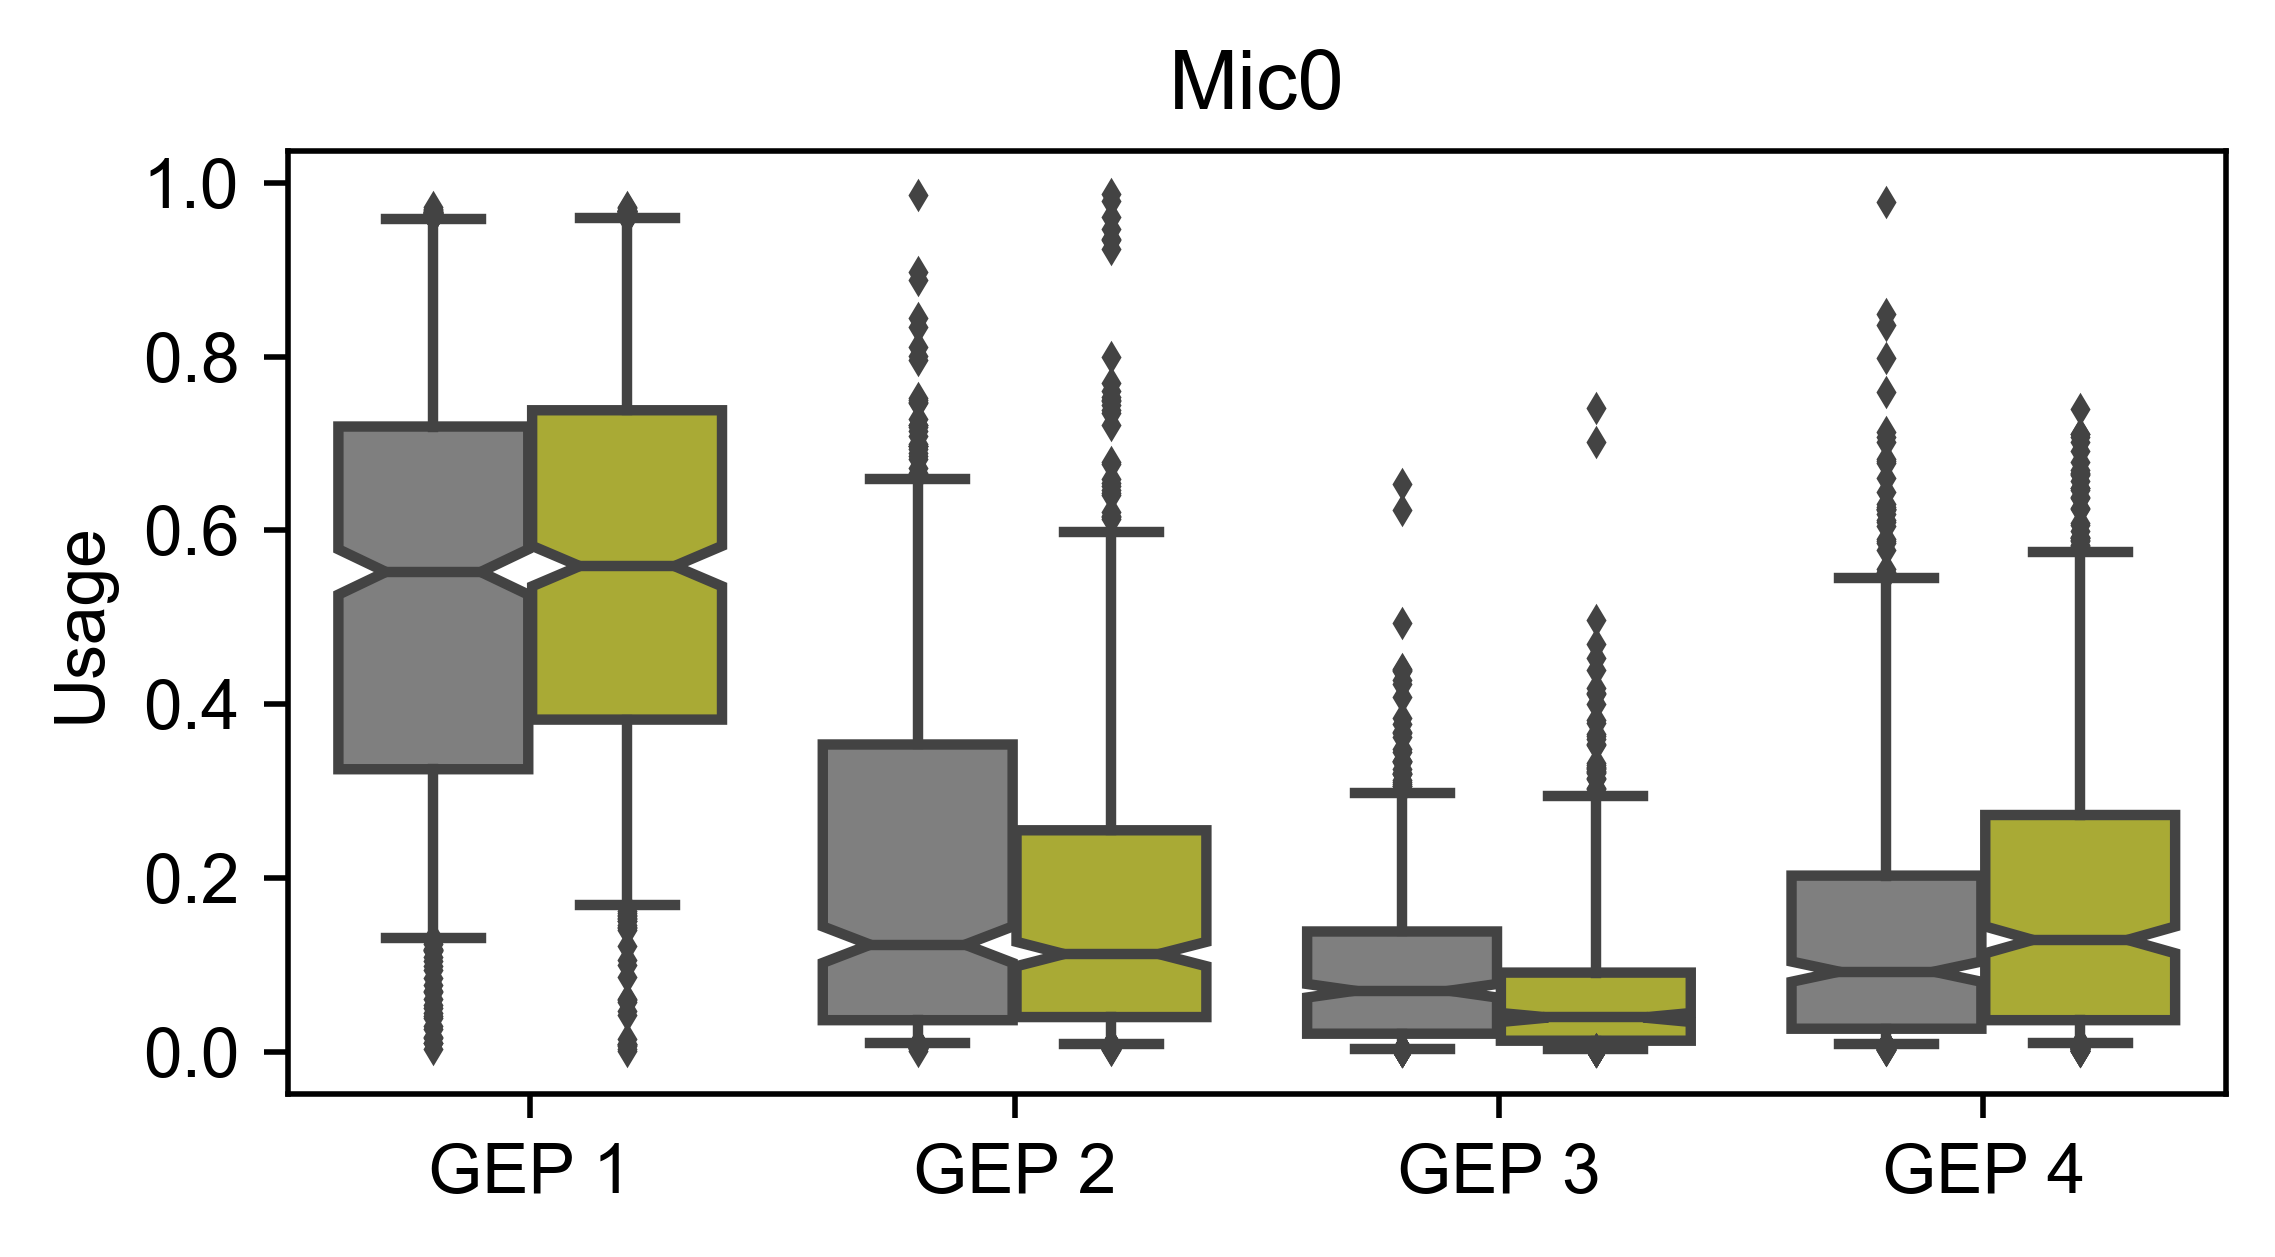

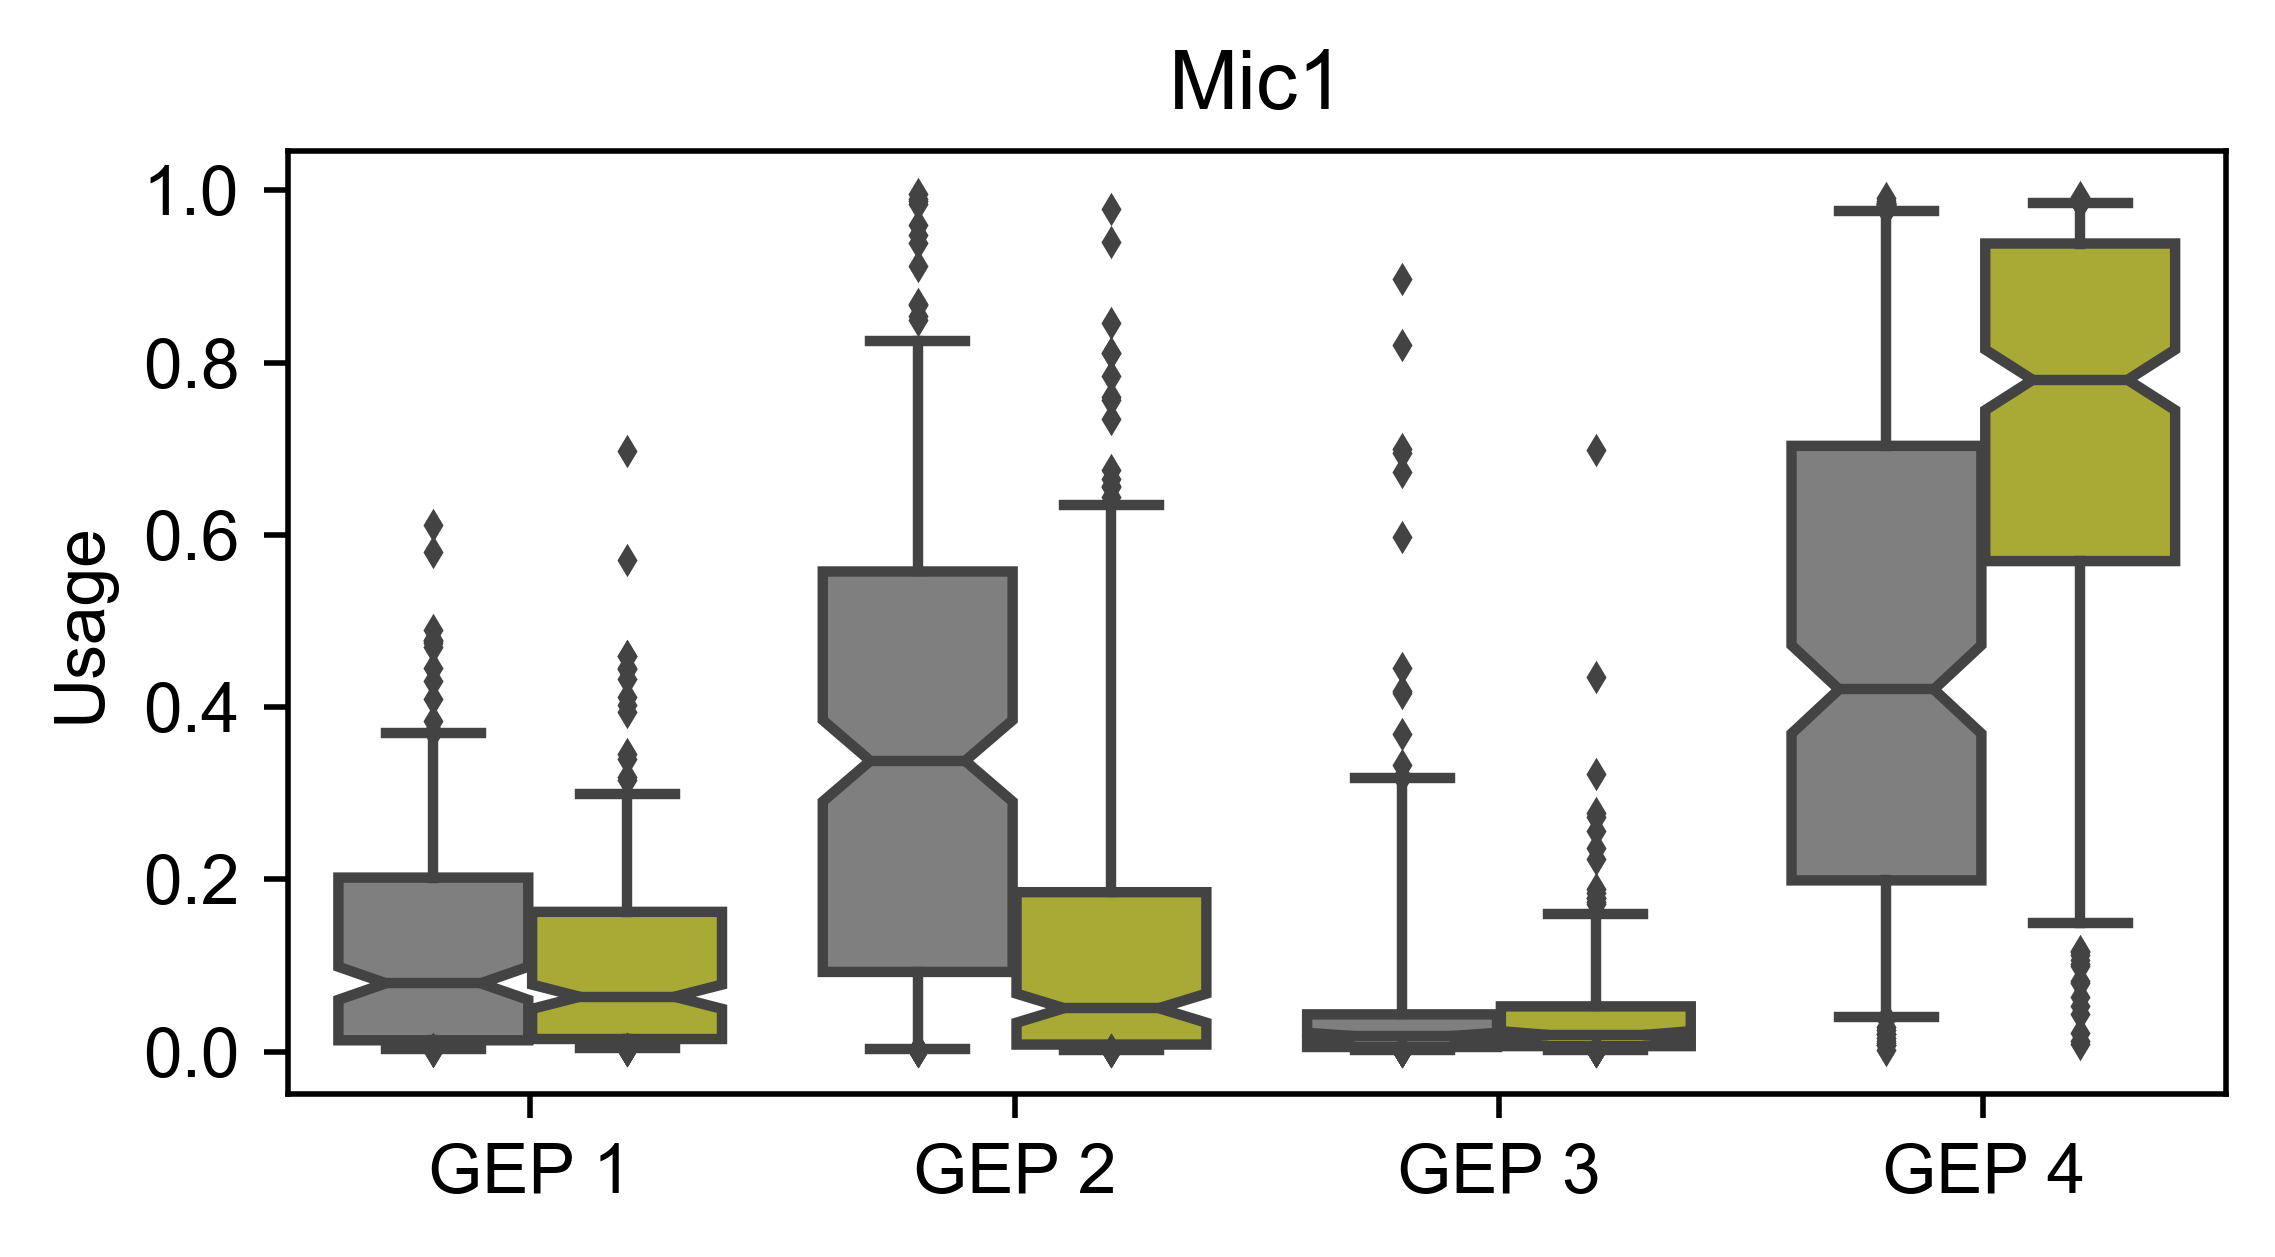

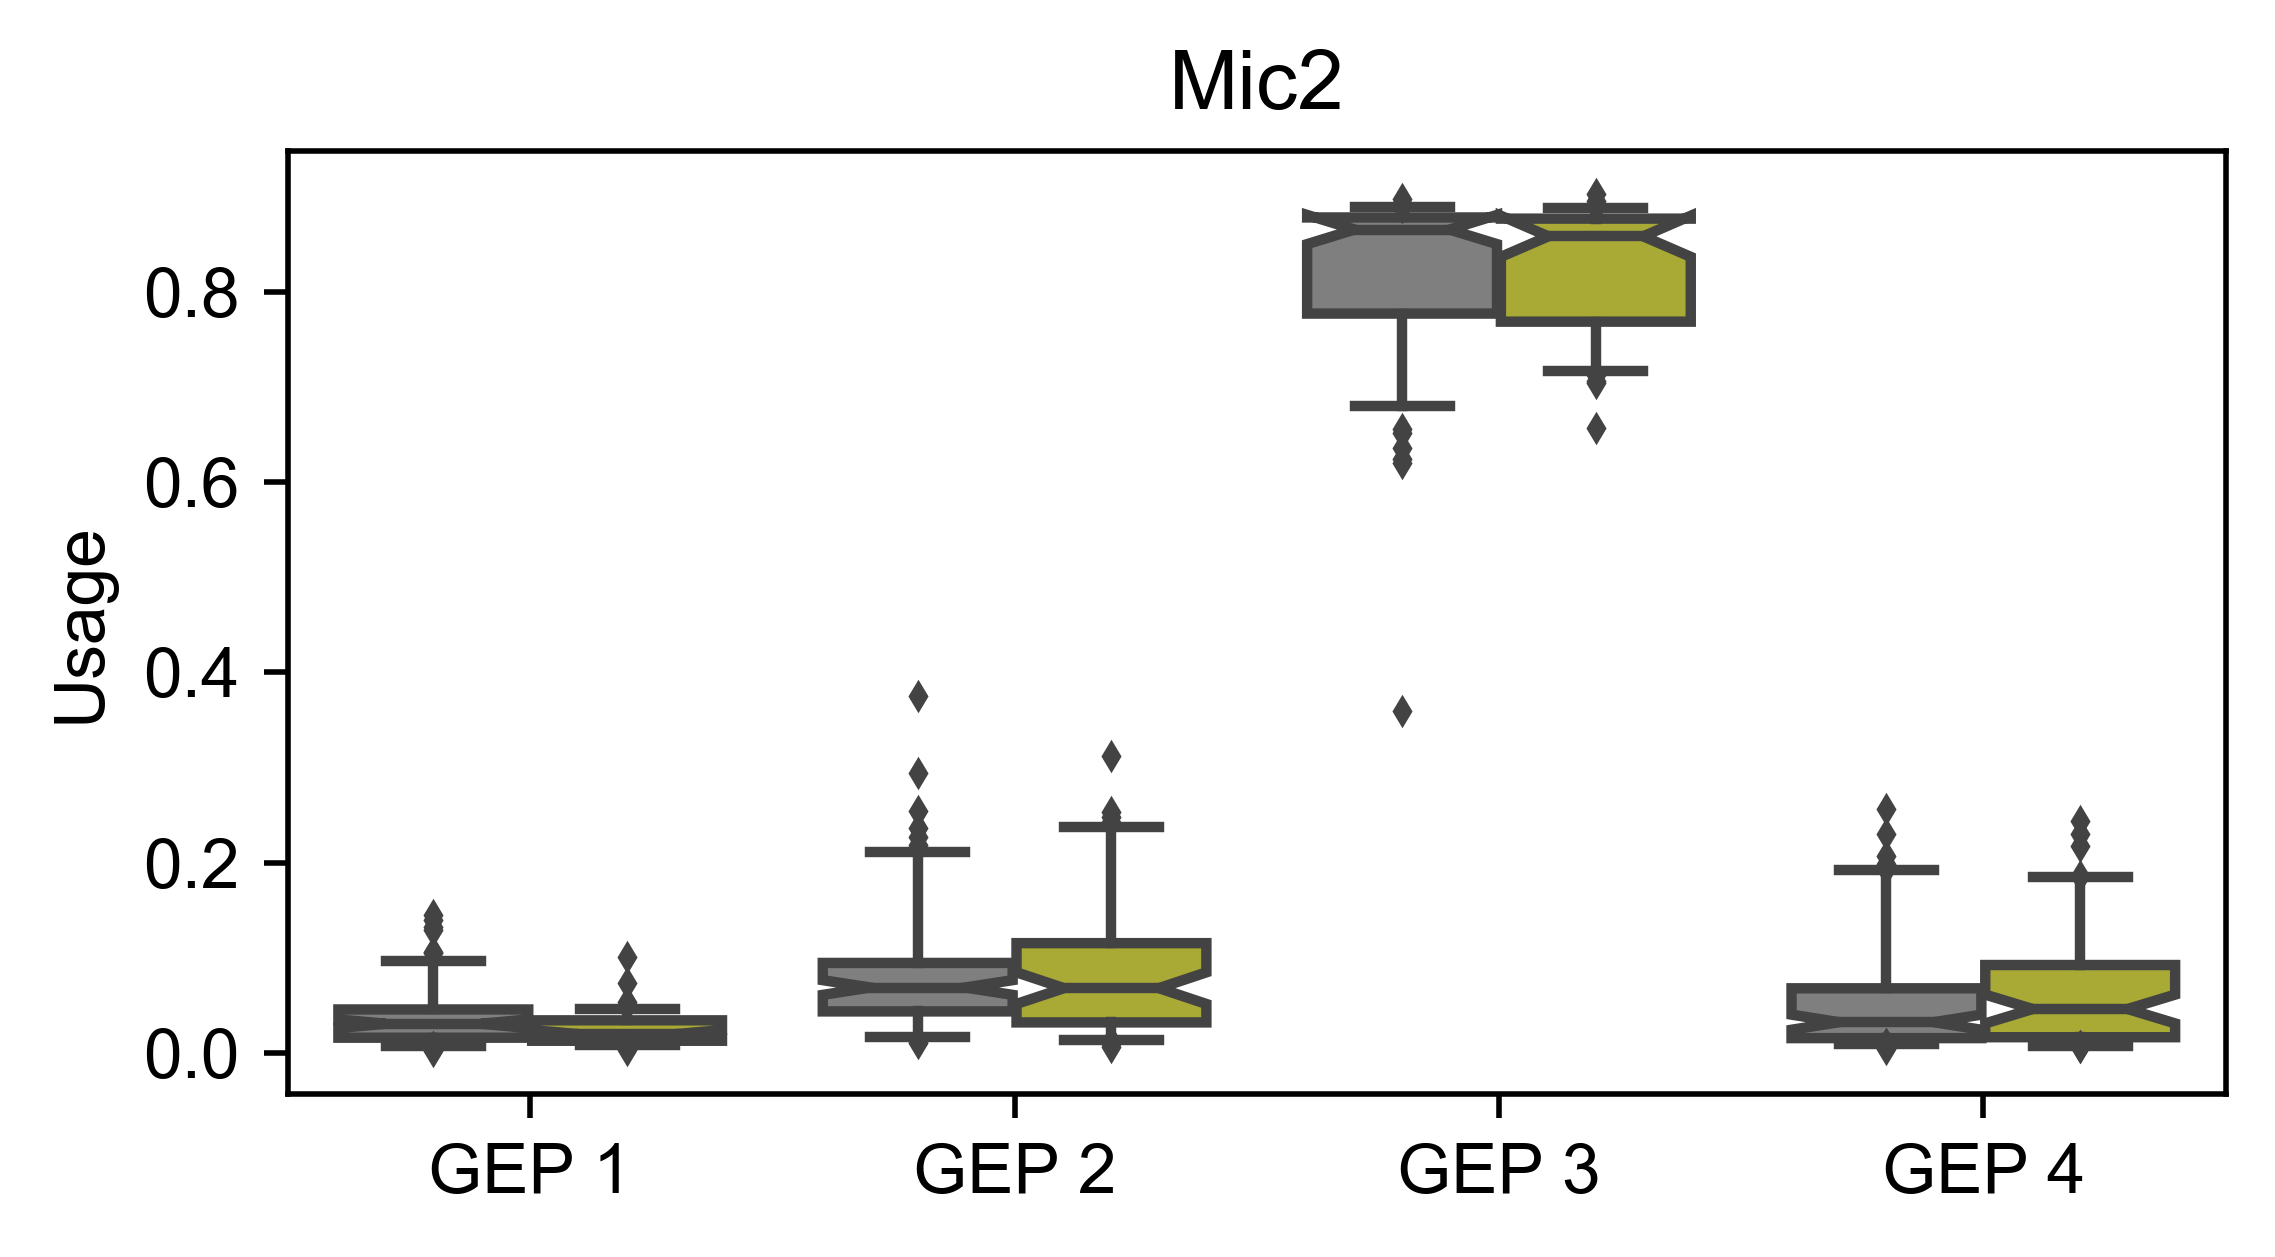

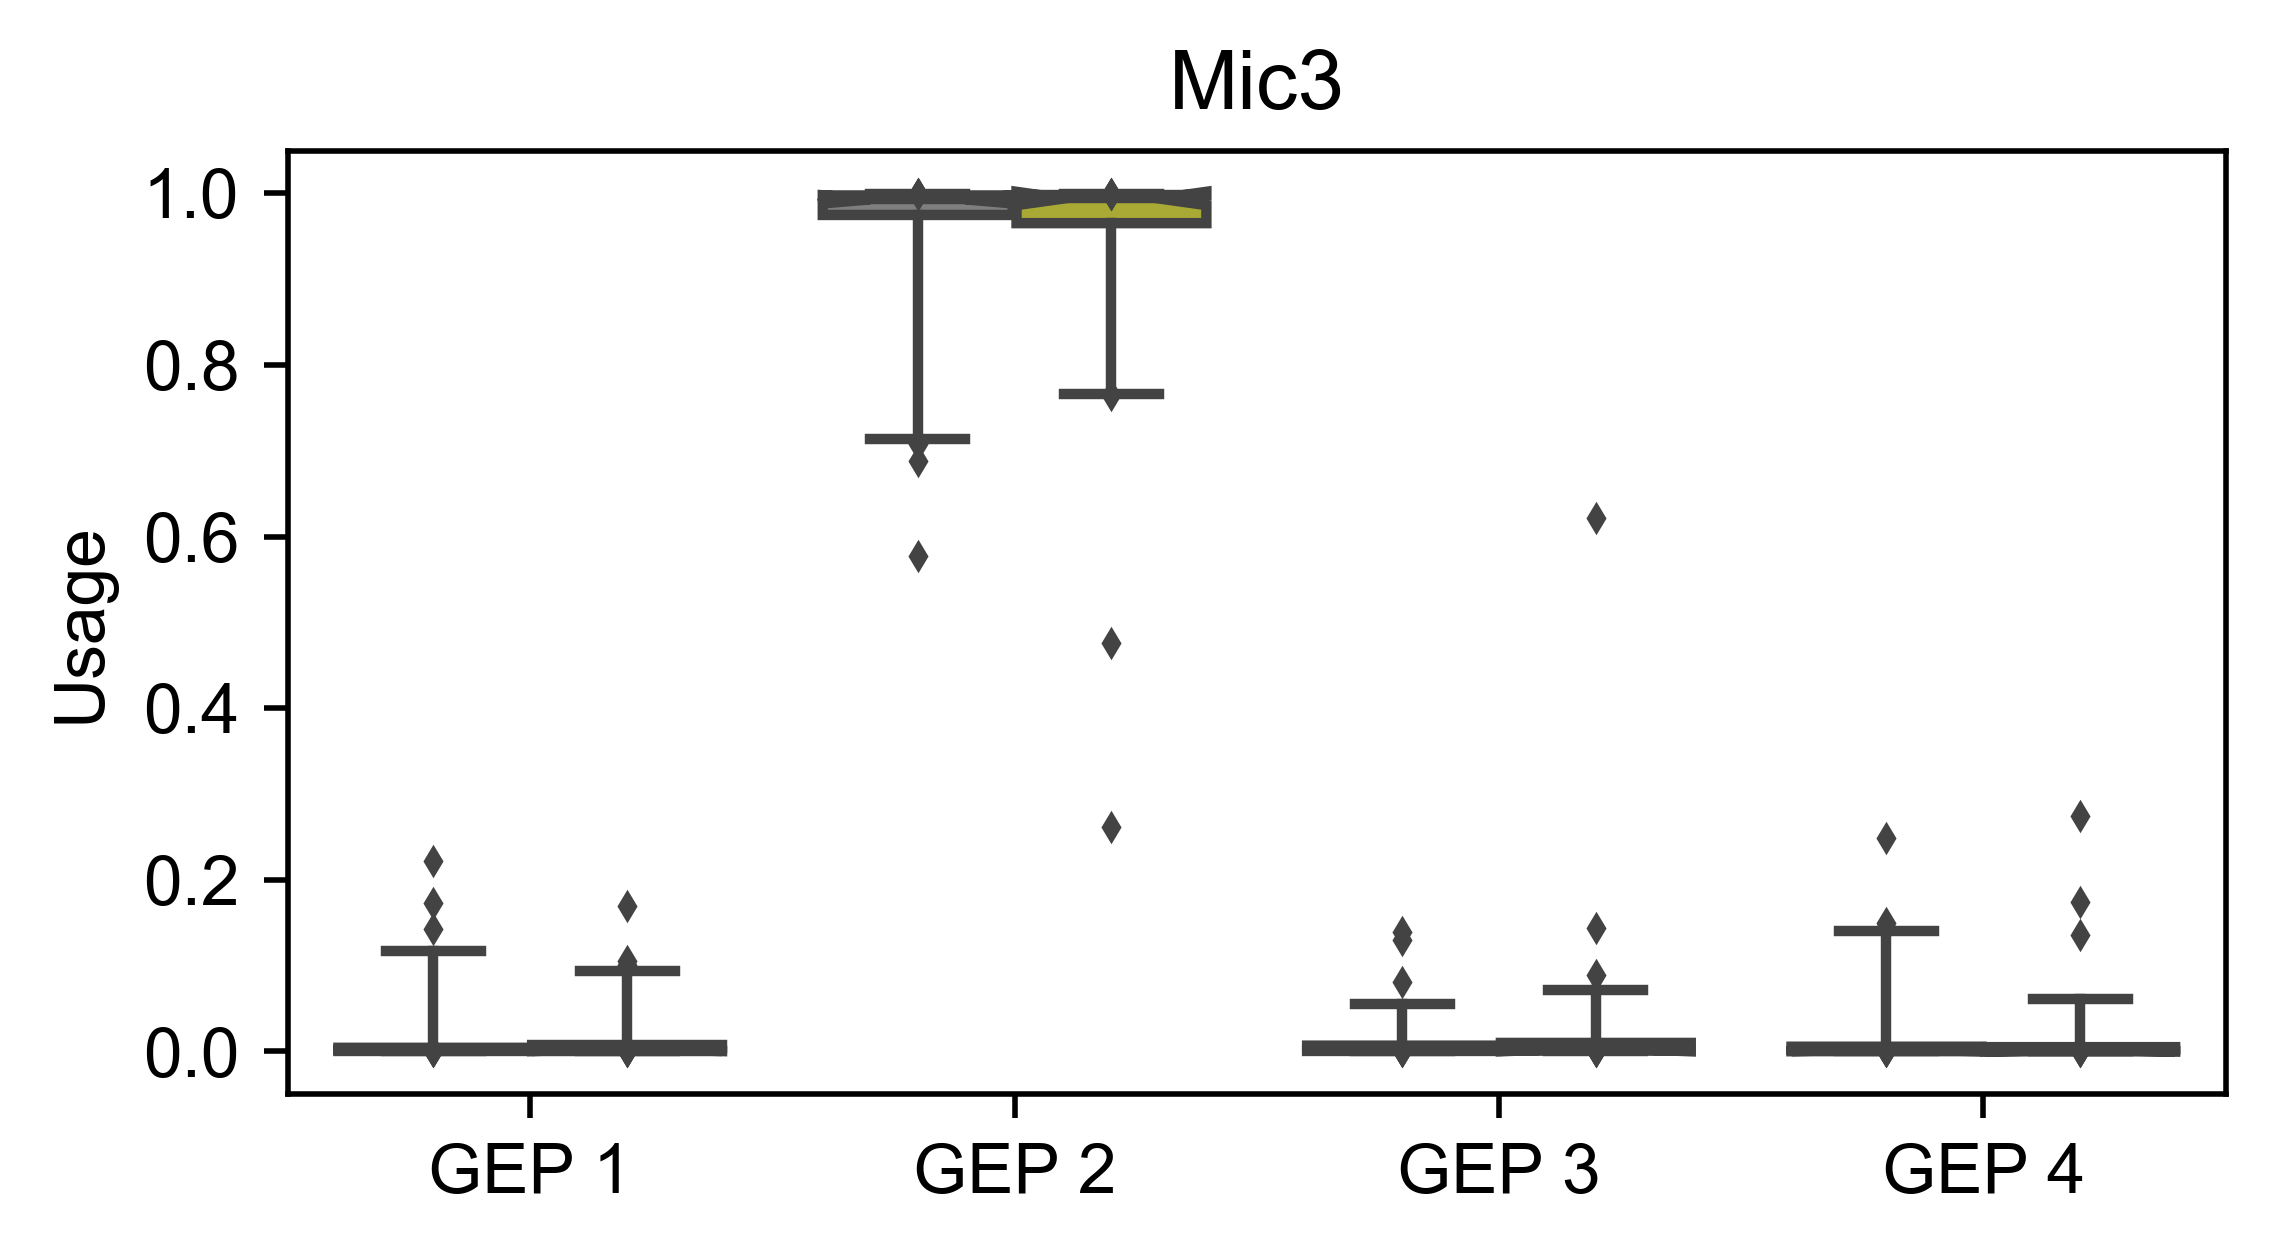

In [11]:
lut2 = {'No': '#7f7f7f', 'Yes': '#bcbd22'}
K = 4
for c in ['Mic0', 'Mic1', 'Mic2', 'Mic3']:
    usage_matrix_norm_labeled = usage.copy()
    gep_usage_by_cluster_flat = usage_matrix_norm_labeled.unstack().reset_index()
    gep_usage_by_cluster_flat.columns = ['GEP', 'Cell', 'Usage']
    gep_usage_by_cluster_flat = pd.merge(left=gep_usage_by_cluster_flat, right=adata.obs[['Subcluster', 'AD']],
                                         left_on='Cell', right_index=True, how='left')
    gep_usage_by_cluster_flat.head()
    clusters = ['Mic0', 'Mic1', 'Mic2', 'Mic3']
    n_clusters = len(clusters)
    order = np.arange(1,K+1)

    subdat = gep_usage_by_cluster_flat.loc[gep_usage_by_cluster_flat['Subcluster']==c,:]
    fig, ax = plt.subplots(figsize=(5,2.5), dpi=500)
    sns.boxplot(x='GEP', y='Usage', hue='AD', data=subdat, order=order,
                ax=ax, fliersize=2, notch=True, whis=[5, 95], palette=lut2)
    ax.set_title(c)
    ax.set_xticklabels(['GEP 1', 'GEP 2', 'GEP 3', 'GEP 4'])
    ax.set_xlabel('')
    ax.legend([],[], frameon=False)

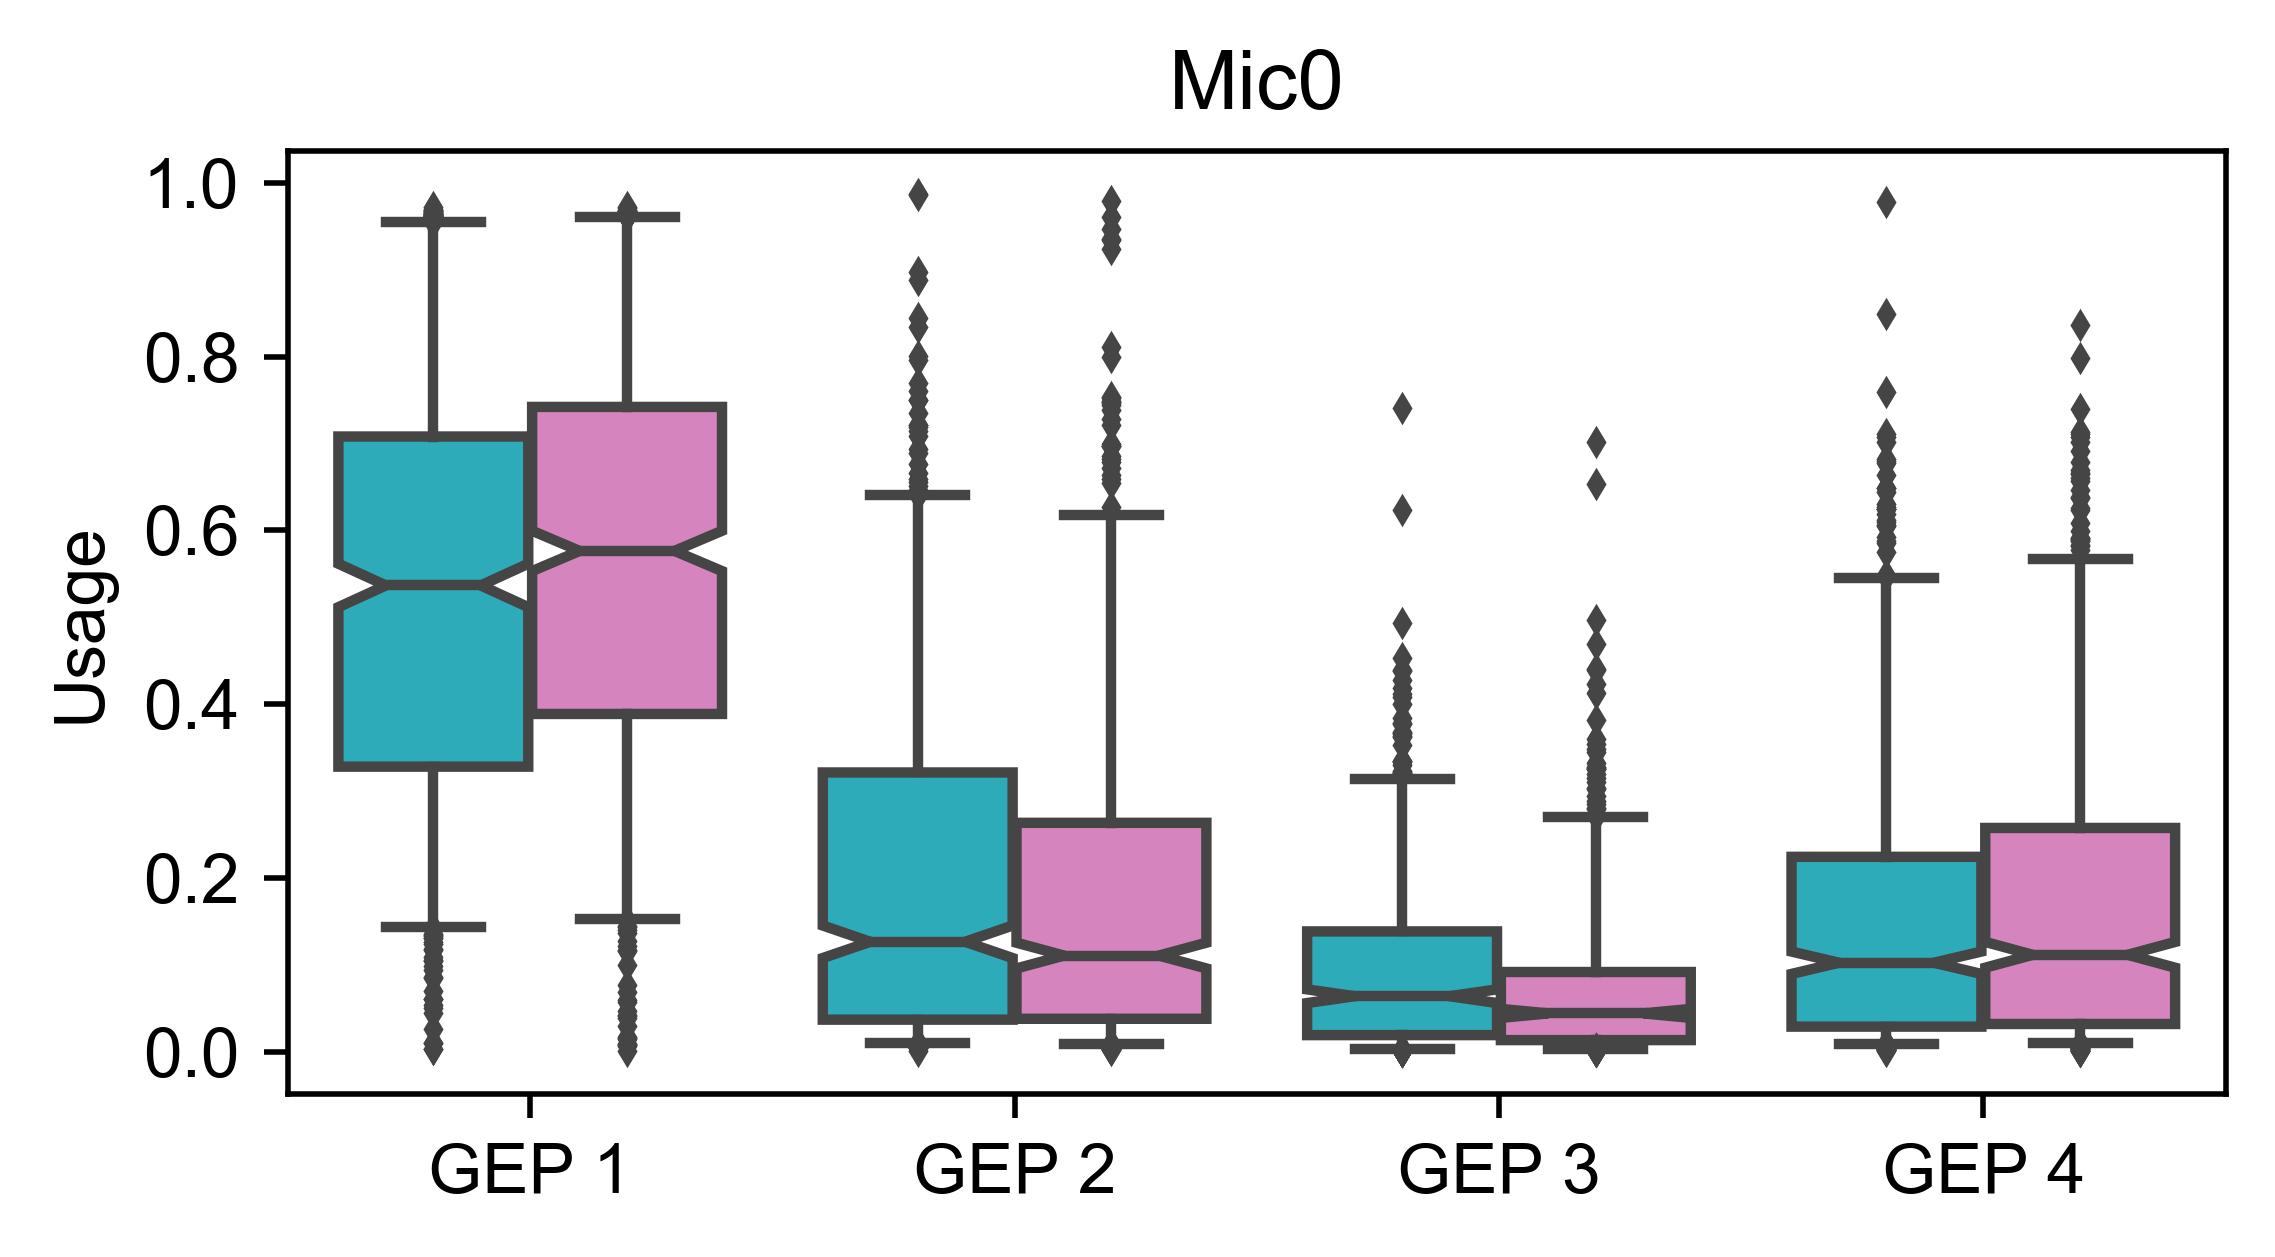

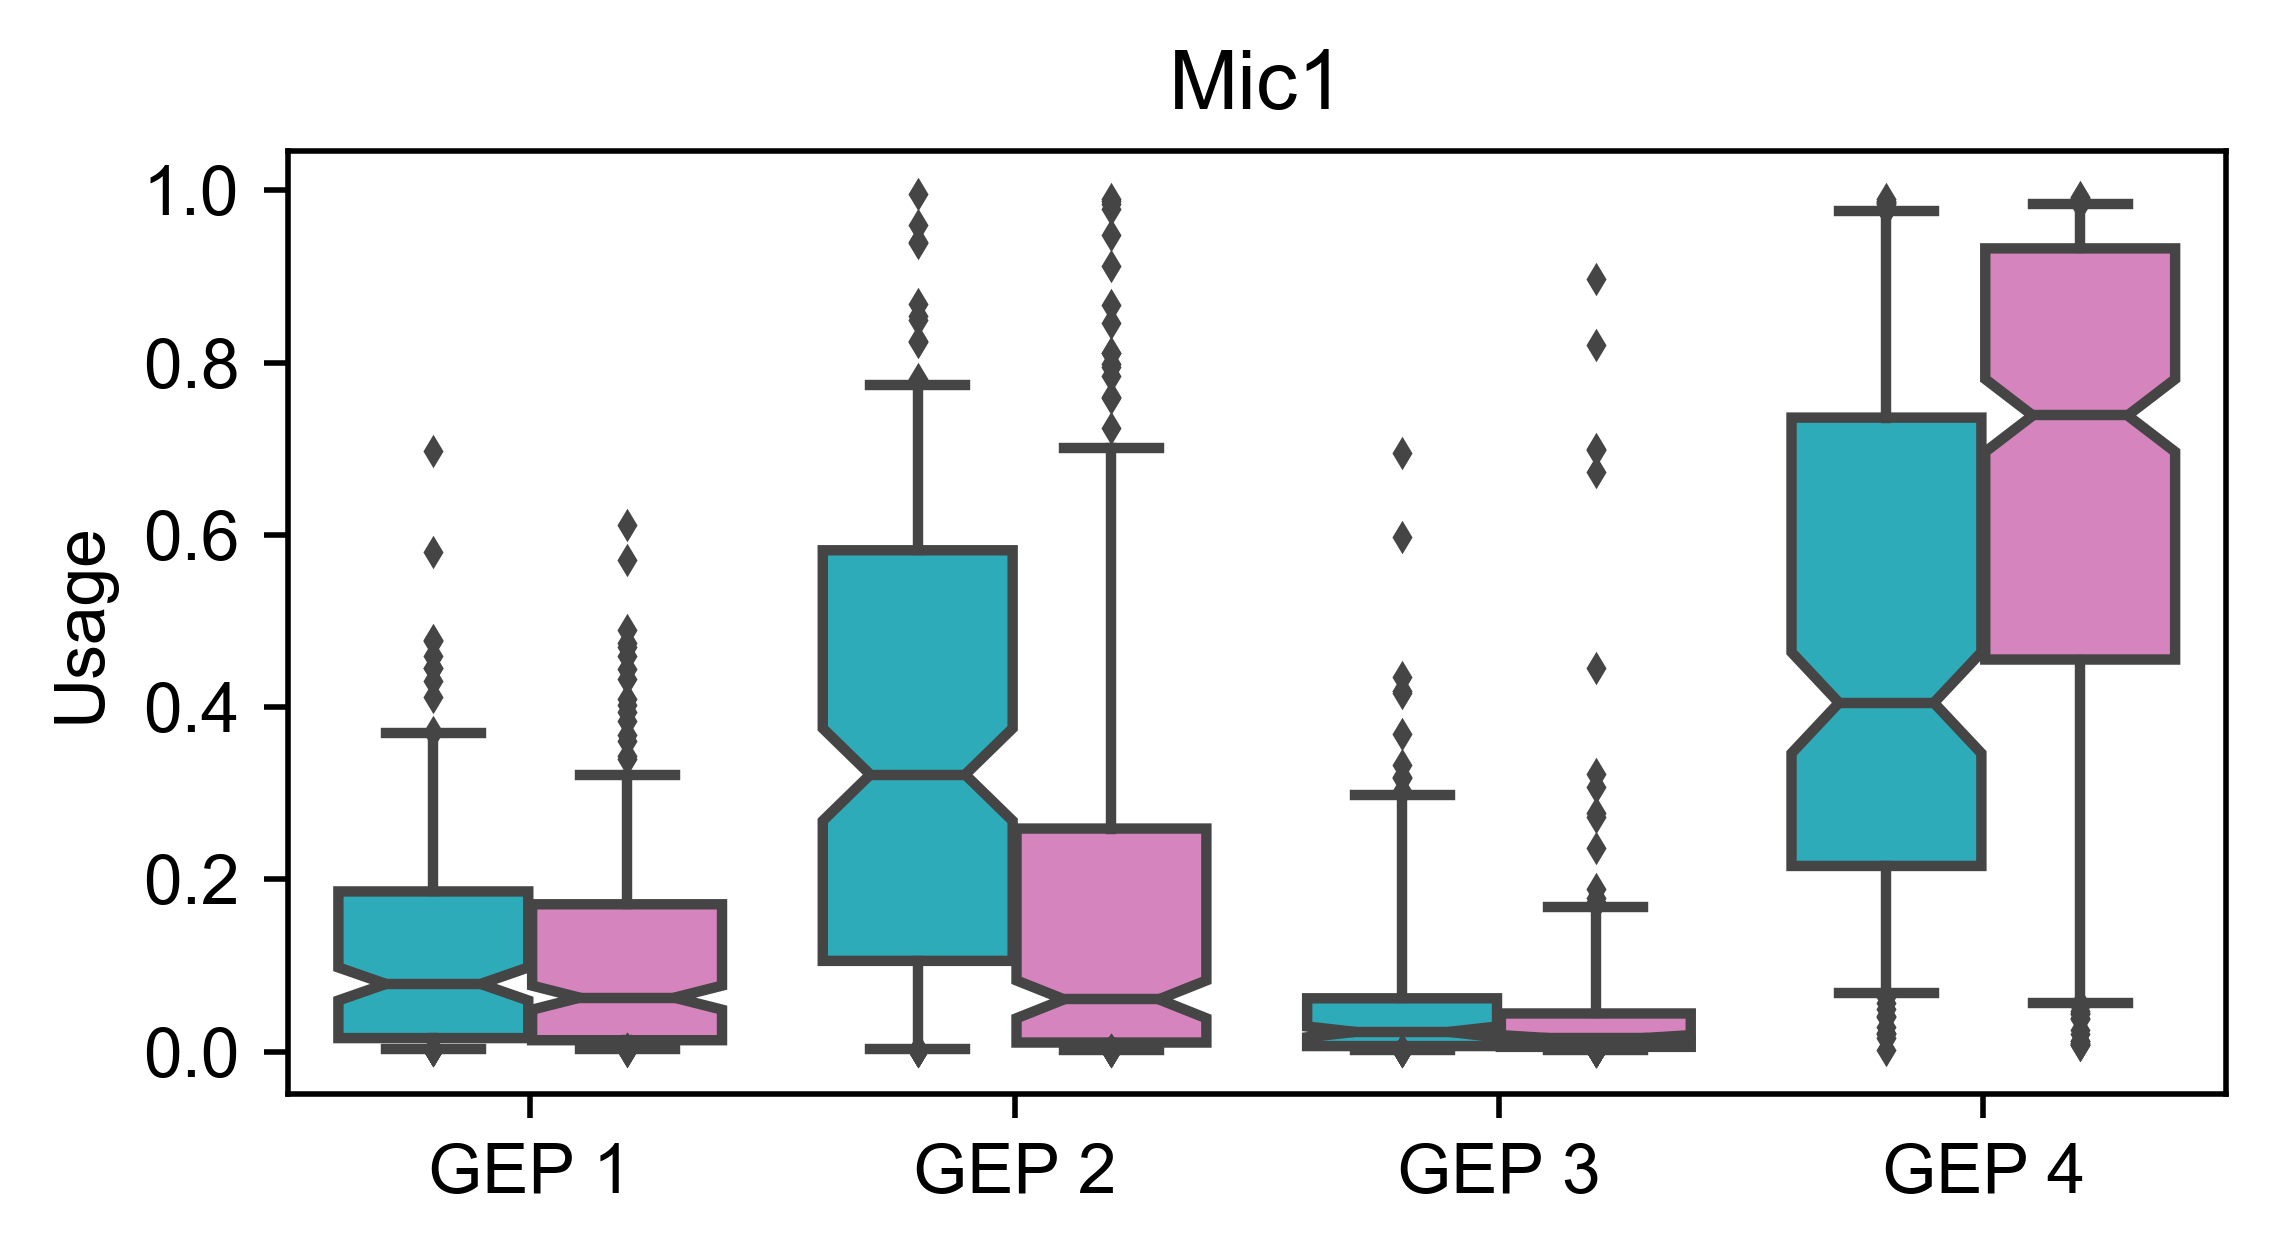

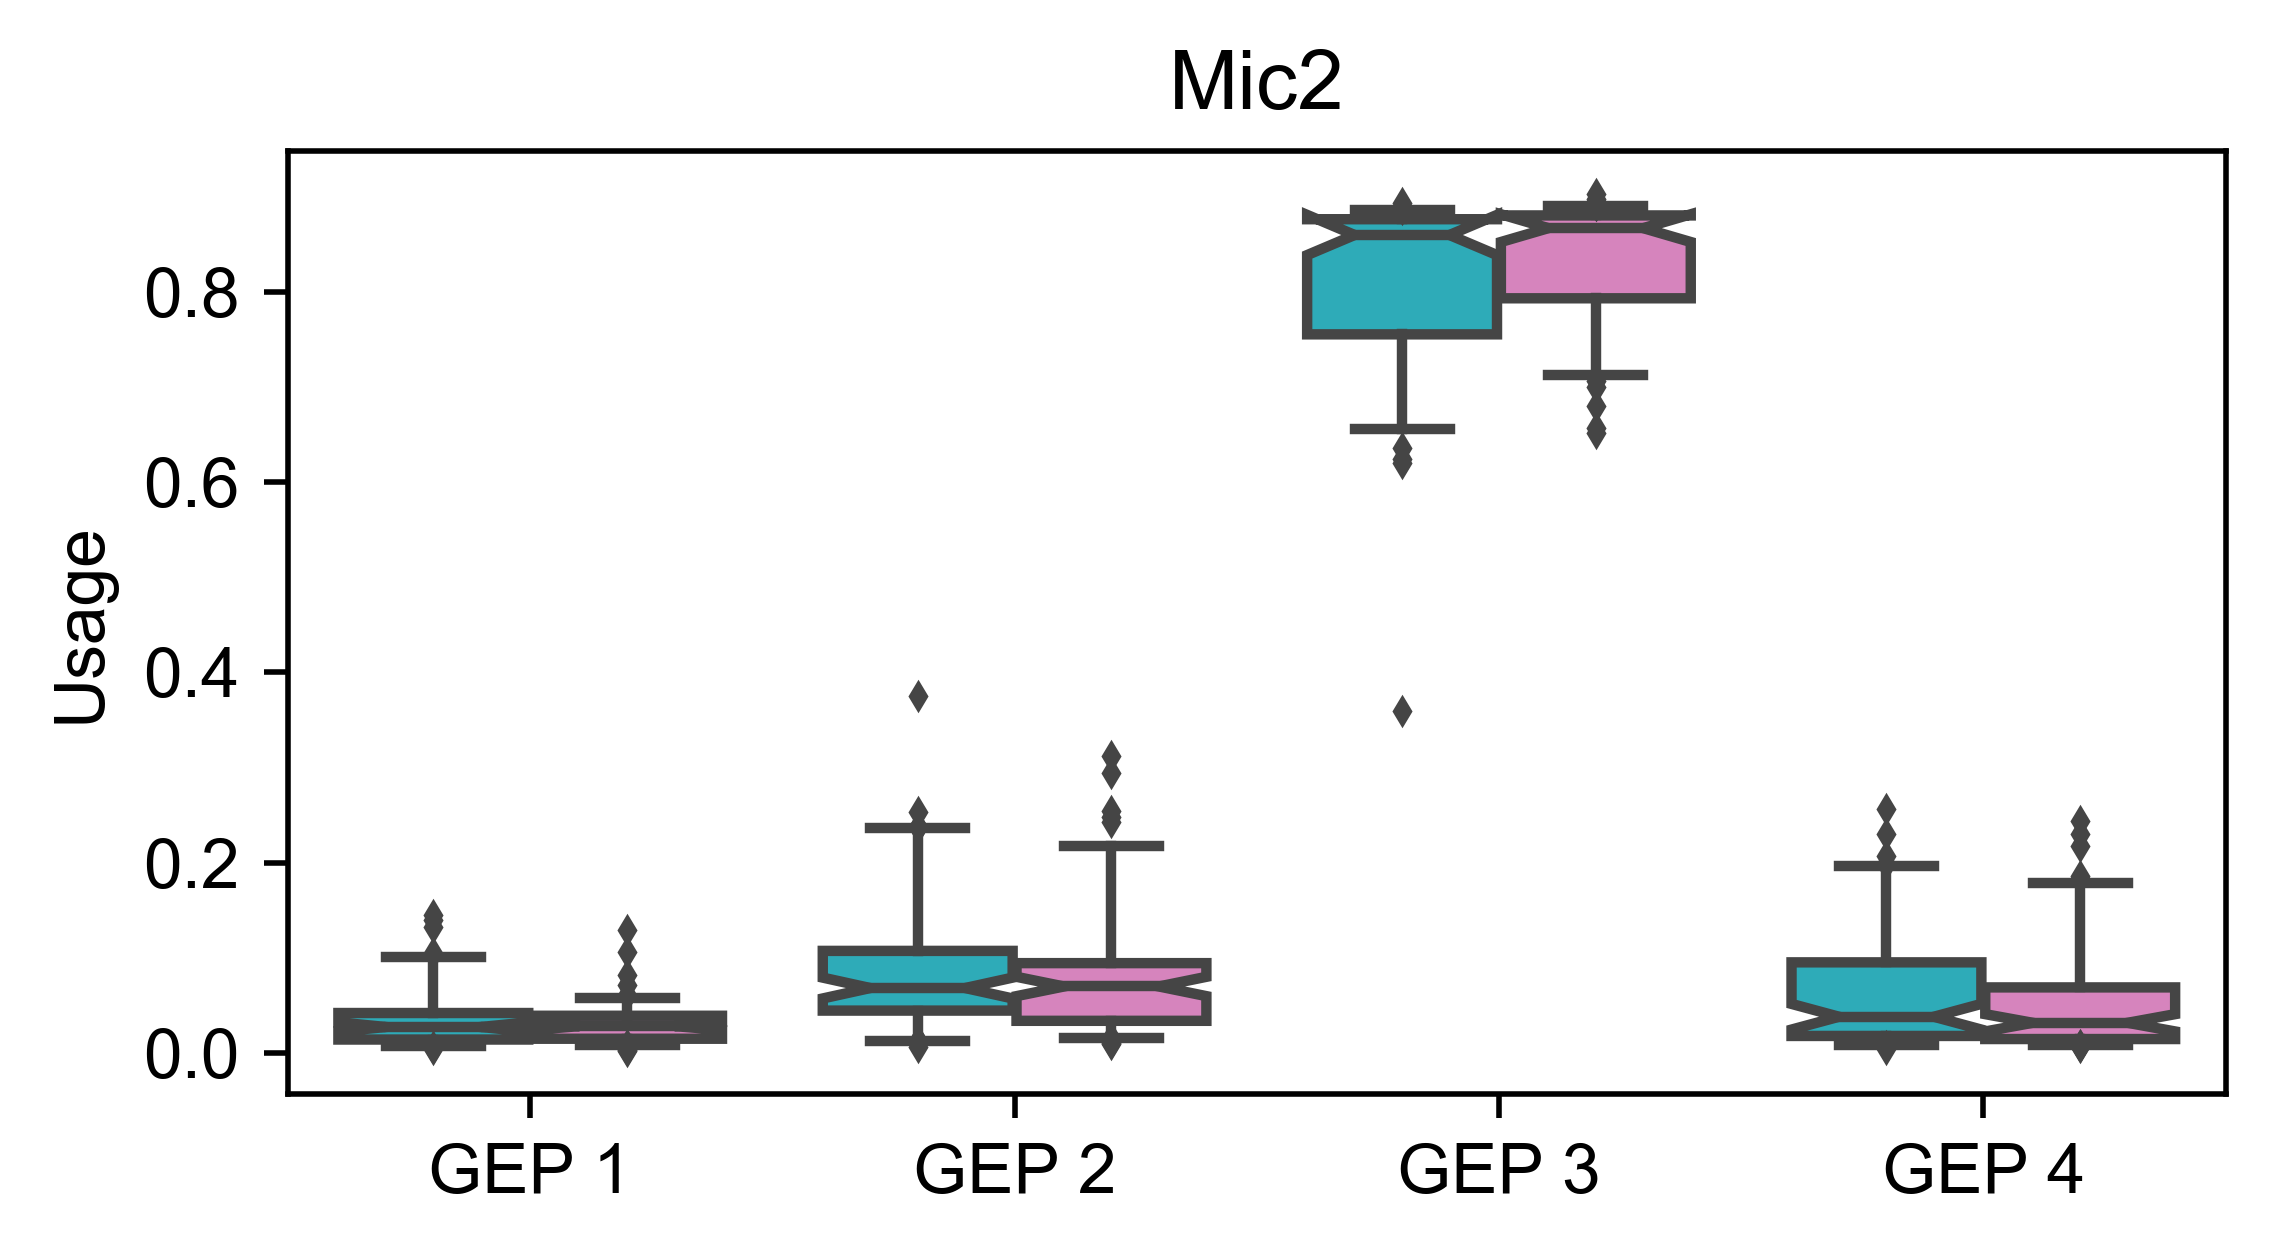

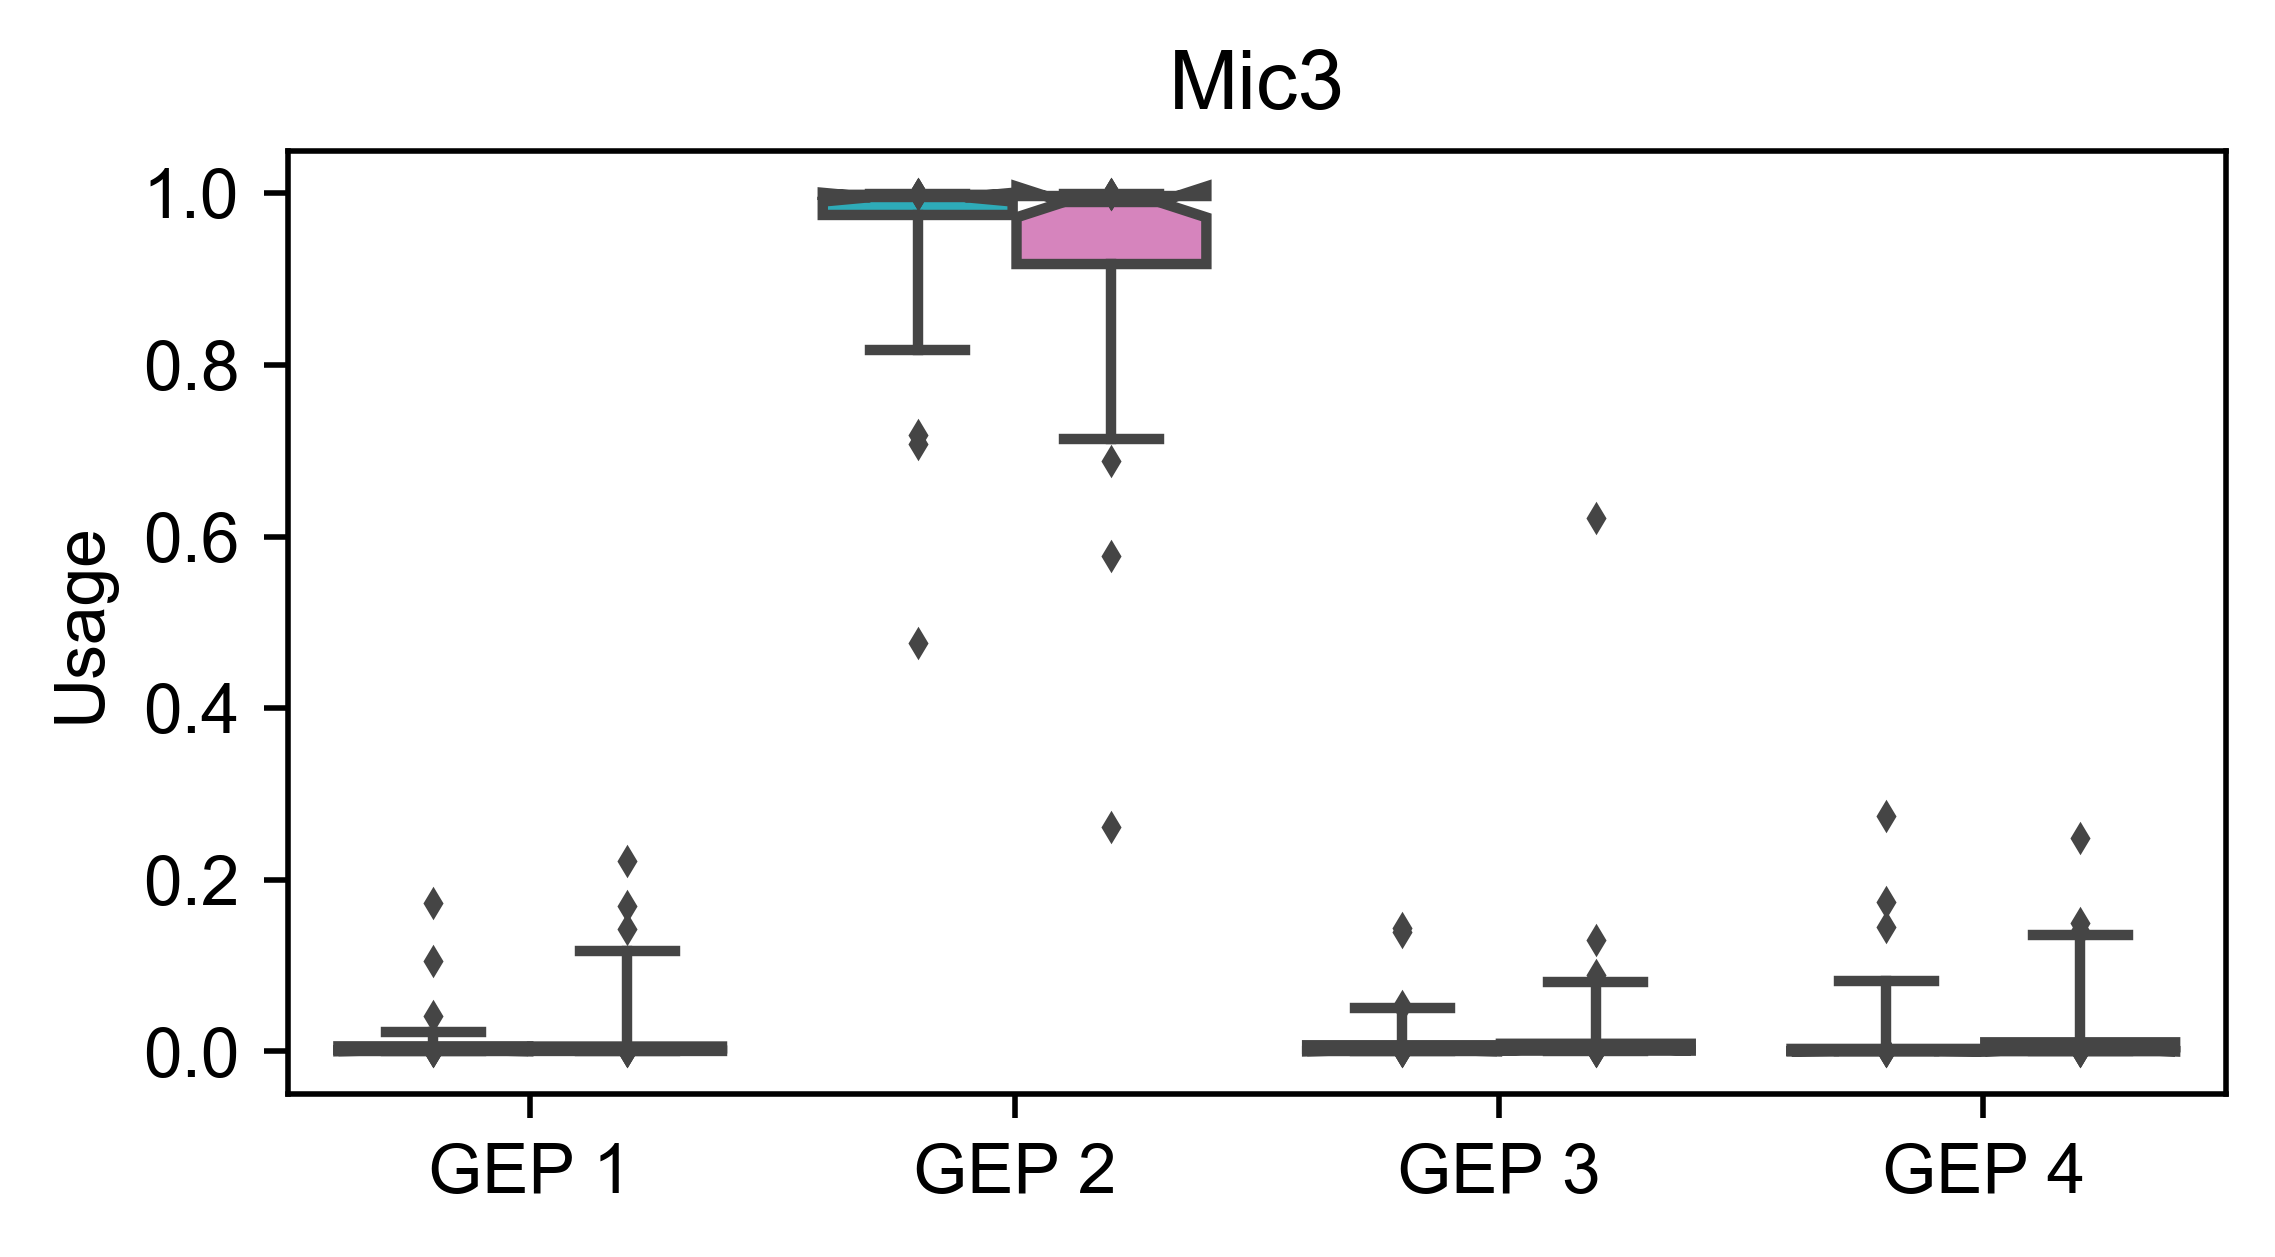

In [16]:
lut2 = {'male': '#17becf', 'female': '#e377c2'}
K = 4
for c in ['Mic0', 'Mic1', 'Mic2', 'Mic3']:
    usage_matrix_norm_labeled = usage.copy()
    gep_usage_by_cluster_flat = usage_matrix_norm_labeled.unstack().reset_index()
    gep_usage_by_cluster_flat.columns = ['GEP', 'Cell', 'Usage']
    gep_usage_by_cluster_flat = pd.merge(left=gep_usage_by_cluster_flat, right=adata.obs[['Subcluster', 'msex']],
                                         left_on='Cell', right_index=True, how='left')
    gep_usage_by_cluster_flat.head()
    clusters = ['Mic0', 'Mic1', 'Mic2', 'Mic3']
    n_clusters = len(clusters)
    order = np.arange(1,K+1)

    subdat = gep_usage_by_cluster_flat.loc[gep_usage_by_cluster_flat['Subcluster']==c,:]
    fig, ax = plt.subplots(figsize=(5,2.5), dpi=500)
    sns.boxplot(x='GEP', y='Usage', hue='msex', data=subdat, order=order,
                ax=ax, fliersize=2, notch=True, whis=[5, 95], palette=lut2)
    ax.set_title(c)
    ax.set_xticklabels(['GEP 1', 'GEP 2', 'GEP 3', 'GEP 4'])
    ax.set_xlabel('')
    ax.legend([],[], frameon=False)
#     plt.savefig('/ysm-gpfs/pi/zhao/yw599/scAAnet/figures/mathy_mic/%s_usage_by_sex_boxplot.pdf' %c, bbox_inches="tight")
#     plt.close()

# Run DEG tests using inferred usage

In [ ]:
from scAAnet.tools import programDEG

In [ ]:
test_use = 'nb_naive'
offset = True
dist = 'ZINB'
rs = 3
K = 4

usage = load_df_from_npz('/home/yw599/project/mathy_data/mathy_mic.usage.wu20.%s.rs%d.k%s.df.npz'%(dist, rs, K))
count = sc.read_h5ad('/gpfs/loomis/pi/zhao2/yw599/jupyter/mathy_data/mic.h5ad')
resultsfn = '/home/yw599/project/mathy_data/mathy_mic.deg.wu20.%s.rs%d.k%s.%s.%s.pkl' % (dist, rs, K, test_use, offset)

usage = usage.to_numpy()
count = pd.DataFrame(count.X.todense(), index=count.obs.index, columns=count.var.index)

results = programDEG(count, usage, test_use, offset, min_counts_per_cell=30)
f = open(resultsfn, 'wb')
pickle.dump(results, f)
f.close()

In [26]:
import pickle
with open('/home/yw599/project/mathy_data/mathy_mic.deg.wu20.%s.rs%d.k%s.nb_naive.True.pkl' % (dist, rs, K), 'rb') as f:
    deg = pickle.load(f)

In [178]:
keys = list(deg.keys())
for i in range(len(deg)):
    re = deg[keys[i]]
    re = re[re['coef.est']>0]
    print('%s:'%(keys[i]), np.sum(re['p.val.adj'] < 0.05))
    print(re.sort_values(by='p.val.adj').head(20))

gep_1: 54
          gene  coef.est         p.val    z.score     p.val.adj
933     SFMBT2  2.115149  4.712558e-99  21.124736  7.672044e-96
381      GRID2  2.334574  1.046544e-89  20.082653  1.703774e-86
939     PLXDC2  1.629822  8.263737e-82  19.158229  1.345336e-78
488   RASGEF1C  2.755644  3.161890e-67  17.322870  5.147557e-64
965   C10orf11  1.560961  6.135358e-66  17.151403  9.988363e-63
1194      GLDN  2.441732  1.454408e-61  16.555781  2.367776e-58
1405      RTTN  2.838670  7.472052e-53  15.301495  1.216450e-49
1619     DSCAM  2.312420  2.429448e-49  14.765931  3.955141e-46
1496   CACNA1A  2.134039  8.379529e-43  13.713928  1.364187e-39
872       NAV2  2.647015  4.554544e-42  13.590580  7.414798e-39
339   NAALADL2  1.737964  9.977068e-26  10.486387  1.624267e-22
866      PDE3B  1.251970  9.641929e-21   9.339906  1.569706e-17
324    KBTBD12  2.096724  2.014635e-20   9.261562  3.279826e-17
301      PTPRG  2.134321  1.735157e-19   9.028831  2.824836e-16
583      NHSL1  1.482369  2.44

In [161]:
Mic0_genes = ['PLXDC2', 'SFMBT2', 'C10orf11'] # GEP 1
Mic1_genes = ['FTL', 'SPP1', 'TMEM163', 'SLC11A1', 'RPLP2', 'RPL28', 'RPS20', 'FTH1'] # GEP 4
Mic2_genes = ['FYN', 'CD247', 'SKAP1', 'BCL11B', 'NKG7', 'STAT4', 'THEMIS', 'PRF1', 'ITK', 'SLC38A1'] # GEP 3
Mic3_genes = ['COLEC12', 'F13A1', 'SEPP1', 'SIGLEC1', 'FGF13', 'MRC1', 'CD163', 'ITSN1', 'NAMPT', 'STARD13'] # GEP 2

In [171]:
GEP_mapping = {1:0, 2:3, 3:2, 4:1}

In [177]:
# Get ranks of markers genes in the corresponding GEP
keys = list(deg.keys())
for i in range(len(deg)):
    re = deg[keys[i]]
    re = re[re['coef.est'] > 0]
    re['rank'] = re['p.val.adj'].rank(ascending=True)
    print(re[re.gene.isin(globals()['Mic'+str(GEP_mapping[i+1])+'_genes'])])

         gene  coef.est         p.val    z.score     p.val.adj  rank
933    SFMBT2  2.115149  4.712558e-99  21.124736  7.672044e-96   1.0
939    PLXDC2  1.629822  8.263737e-82  19.158229  1.345336e-78   3.0
965  C10orf11  1.560961  6.135358e-66  17.151403  9.988363e-63   5.0
         gene  coef.est         p.val    z.score     p.val.adj  rank
425     SEPP1  4.401746  8.381251e-55  15.590999  1.364468e-51   4.0
491     F13A1  4.459115  2.399776e-98  21.047714  3.906835e-95   1.0
637     NAMPT  3.605382  6.109683e-58  16.045870  9.946563e-55   3.0
707     FGF13  5.016387  7.407705e-25  10.295185  1.205974e-21  18.0
938      MRC1  2.322225  5.447674e-40  13.235850  8.868813e-37   6.0
1006    CD163  3.080239  3.370428e-50  14.898504  5.487056e-47   5.0
1097  STARD13  1.970455  2.402374e-30  11.448143  3.911064e-27   9.0
1380  COLEC12  6.930692  1.638860e-32  11.872802  2.668064e-29   8.0
1421  SIGLEC1  4.412073  1.991715e-23   9.973458  3.242512e-20  19.0
1614    ITSN1  2.495727  3.279194e

/ysm-gpfs/pi/zhao/yw599/conda_envs/scvi/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/ysm-gpfs/pi/zhao/yw599/conda_envs/scvi/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/ysm-gpfs/pi/zhao/yw599/conda_envs/scvi/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

### Enrichment of marker genes in each GEP

In [44]:
from scipy.stats import hypergeom

In [45]:
markers = pd.read_csv('~/project/mathy_data/markers.subcluster.csv')
markers = markers[markers.subpopulation.isin(['Mic0', 'Mic1', 'Mic2', 'Mic3'])]
markers_sub = markers[markers['gene.name'].isin(gene_score.index)]

In [46]:
re = np.zeros((4, 4))
for gep in range(4):
    for mic in range(4):
        re_deg = deg['gep_%d' %(gep+1)]
        re_deg = re_deg.sort_values(by='p.val.adj')
        re_deg_pos = re_deg[(re_deg['z.score']>0) & (re_deg['p.val.adj']<0.05)]
        gep_genes = re_deg_pos.gene
        mic_genes = markers_sub[markers_sub['subpopulation'] == 'Mic%d'%mic]['gene.name']
        ol_genes = set(gep_genes).intersection(mic_genes)
        x = len(ol_genes)
        bg = 2000
        m = len(mic_genes)
        k = len(gep_genes)
        re[gep, mic] = hypergeom.sf(x-1, bg, m, k)
re = pd.DataFrame(re, index=['GEP %d' %i for i in range(1, 5)], columns=['Mic%d' %i for i in range(4)])
re_bon = re*16
re_bon[re_bon > 1] = 1

In [127]:
re_bon

Mic0          Mic1          Mic2          Mic3
GEP 1  2.658986e-12  1.000000e+00  1.000000e+00  1.000000e+00
GEP 2  1.000000e+00  3.412722e-04  1.000000e+00  2.123363e-40
GEP 3  1.000000e+00  1.000000e+00  3.088427e-54  1.000000e+00
GEP 4  1.000000e+00  3.875725e-43  3.253500e-04  1.000000e+00

<AxesSubplot:>

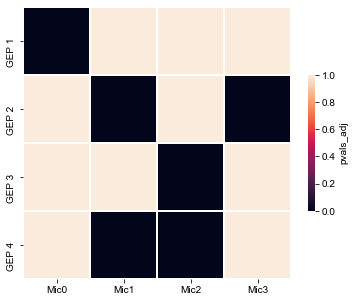

In [123]:
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(re_bon, ax=ax, 
           cbar_kws={"shrink": 0.5, "label": "pvals_adj"},
           linecolor="white", linewidths=0.01)


<AxesSubplot:>

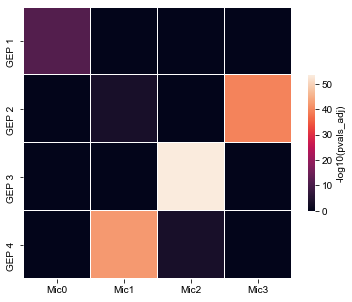

In [49]:
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(-np.log10(re_bon), ax=ax, 
           cbar_kws={"shrink": 0.5, "label": "-log10(pvals_adj)"},
           linecolor="white", linewidths=0.01)

In [128]:
re = np.zeros((16, 4))
i = 0
for gep in range(4):
    for mic in range(4):
        re_deg = deg['gep_%d' %(gep+1)]
        re_deg = re_deg.sort_values(by='p.val.adj')
        re_deg_pos = re_deg[(re_deg['z.score']>0) & (re_deg['p.val.adj']<0.05)]
        gep_genes = re_deg_pos.gene
        mic_genes = markers_sub[markers_sub['subpopulation'] == 'Mic%d'%mic]['gene.name']
        ol_genes = set(gep_genes).intersection(mic_genes)
        x = len(ol_genes)
        bg = 2000
        m = len(mic_genes)
        k = len(gep_genes)
        re[i, 0] = hypergeom.sf(x-1, bg, m, k)
        re[i, 1] = x
        re[i, 2] = m
        re[i, 3] = k
        i += 1

In [129]:
re = pd.DataFrame({"pvals":re[:,0], "hits":re[:,1], "mic_genes":re[:,2], "gep_genes":re[:,3], 
                   "GEP":['GEP %d'%i for i in np.repeat(np.arange(1,5), 4)],
                   "Subcluster":["Mic%d" %i for i in np.arange(4)]*4})
re['pvals_adj'] = re['pvals']*re.shape[0]
re['pvals_adj'][re['pvals_adj']>1] =1 

/ysm-gpfs/pi/zhao/yw599/conda_envs/scvi/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [130]:
re

pvals  hits  mic_genes  gep_genes    GEP Subcluster     pvals_adj
0   1.661866e-13   8.0        8.0       54.0  GEP 1       Mic0  2.658986e-12
1   1.000000e+00   0.0       37.0       54.0  GEP 1       Mic1  1.000000e+00
2   8.800635e-01   1.0       76.0       54.0  GEP 1       Mic2  1.000000e+00
3   1.000000e+00   0.0       37.0       54.0  GEP 1       Mic3  1.000000e+00
4   1.000000e+00   0.0        8.0      113.0  GEP 2       Mic0  1.000000e+00
5   2.132951e-05  10.0       37.0      113.0  GEP 2       Mic1  3.412722e-04
6   8.156905e-01   3.0       76.0      113.0  GEP 2       Mic2  1.000000e+00
7   1.327102e-41  34.0       37.0      113.0  GEP 2       Mic3  2.123363e-40
8   1.000000e+00   0.0        8.0      193.0  GEP 3       Mic0  1.000000e+00
9   9.774215e-01   1.0       37.0      193.0  GEP 3       Mic1  1.000000e+00
10  1.930267e-55  63.0       76.0      193.0  GEP 3       Mic2  3.088427e-54
11  4.856610e-01   4.0       37.0      193.0  GEP 3       Mic3  1.000000e+00
12  1.000000e+00   0.0        8.0       43.0  GEP 4       Mic0  1.000000e+00
13  2.422328e-44  28.0       37.0       43.0  GEP 4       Mic1  3.875725e-43
14  2.033437e-05   9.0       76.0       43.0  GEP 4       Mic2  3.253500e-04
15  5.558462e-01   1.0       37.0       43.0  GEP 4       Mic3  1.000000e+00

## Top 20 DEGs

In [179]:
# Save DEG results sorted by adjusted p values and separated by the sign of coefs to file
keys = list(deg.keys())
for i in range(len(deg)):
    re = deg[keys[i]]
    re = re.sort_values(by='p.val.adj')
    re_pos = re[re['z.score']>0]
    re_neg = re[re['z.score']<0]
    re_pos.to_excel('/home/yw599/project/mathy_data/mathy_mic.deg.%s.pos.wu20%s.rs%d.k%s.nb_naive.True.xlsx' 
                    % (keys[i], dist, rs, K))
    re_neg.to_excel('/home/yw599/project/mathy_data/mathy_mic.deg.%s.neg.wu20%s.rs%d.k%s.nb_naive.True.xlsx' 
                    % (keys[i], dist, rs, K))

In [33]:
gep_num = 1 # substitue with 2, 3, or 4
gene_num = 20
re = deg['gep_%d'%gep_num]
re = re.sort_values(by='z.score', ascending=False)
re_pos = re[re['z.score']>0]
gene_list = list(re_pos.gene[:gene_num])

In [34]:
adata_c = sc.read_h5ad('/ysm-gpfs/pi/zhao/yw599/jupyter/ROSMAP_data/Mathy2019/mic.h5ad')
for i in range(usage.shape[1]):
    adata_c.obs["GEP %s"%(i+1)] = usage.iloc[:,i]
sc.pp.normalize_total(adata_c, target_sum=1e4)
sc.pp.log1p(adata_c)
adata_c.raw = adata_c    
exp_beta = pd.DataFrame(adata_c.raw.X.todense(), index=adata_c.obs.index, columns=adata_c.var.index)
exp_beta = exp_beta[gene_list]
exp_beta = exp_beta.sub(exp_beta.min(axis=0), axis='columns').div(exp_beta.max(axis=0)-exp_beta.min(axis=0), axis='columns')
exp_beta['GEP %d usage'%gep_num] = adata_c.obs['GEP %d'%gep_num].values
cell_sorted = exp_beta.sort_values(by='GEP %d usage'%gep_num).index
exp_beta = exp_beta.loc[cell_sorted,:]

In [29]:
sns.set(font_scale=1.11)

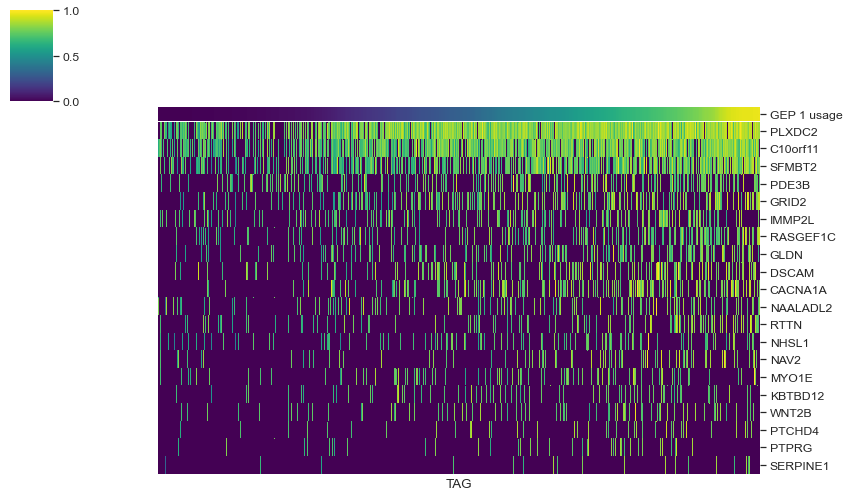

In [56]:
# GEP 1
cmap = sns.color_palette("viridis", as_cmap=True)
col_colors = exp_beta.iloc[:,20].map(cmap)

# Order gene by the area under curve (y: expression, x: cell usage)
auc = np.array([np.trapz(y=exp_beta[g].values, x=exp_beta['GEP %d usage' % gep_num].values) for g in gene_list])
order = auc.argsort()[::-1]

sns.clustermap(exp_beta.iloc[:,:20].transpose().iloc[order,:], xticklabels=False, figsize=(12,7),
               row_cluster=False, col_cluster=False, col_colors=col_colors, cmap=cmap)

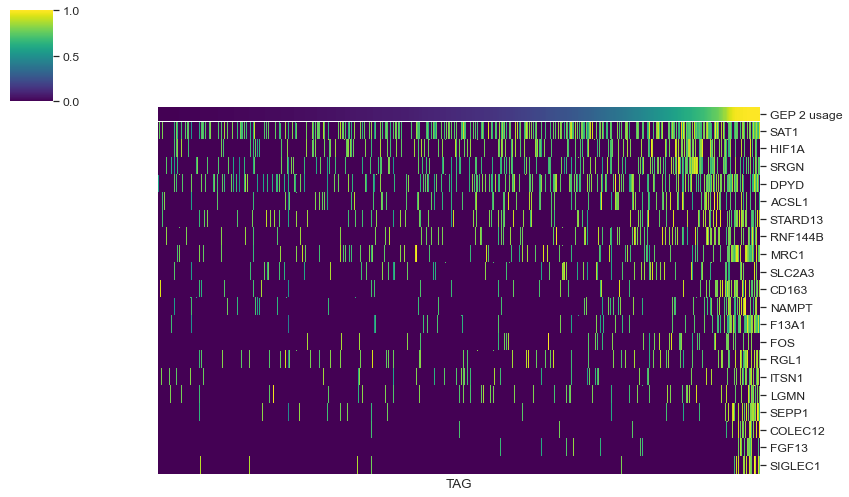

In [61]:
# GEP 2
cmap = sns.color_palette("viridis", as_cmap=True)
col_colors = exp_beta.iloc[:,20].map(cmap)

# Order gene by the area under curve (y: expression, x: cell usage)
auc = np.array([np.trapz(y=exp_beta[g].values, x=exp_beta['GEP %d usage' % gep_num].values) for g in gene_list])
order = auc.argsort()[::-1]

sns.clustermap(exp_beta.iloc[:,:20].transpose().iloc[order,:], xticklabels=False, figsize=(12,7),
               row_cluster=False, col_cluster=False, col_colors=col_colors, cmap=cmap)

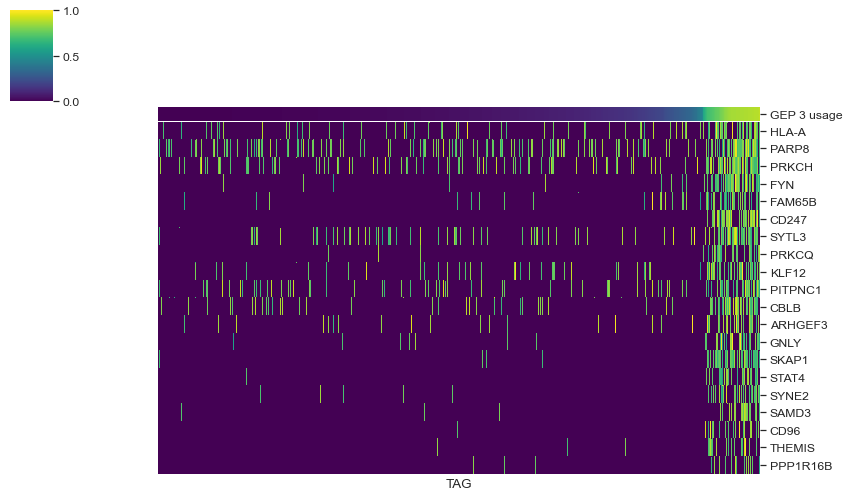

In [66]:
# GEP 3
cmap = sns.color_palette("viridis", as_cmap=True)
col_colors = exp_beta.iloc[:,20].map(cmap)

# Order gene by the area under curve (y: expression, x: cell usage)
auc = np.array([np.trapz(y=exp_beta[g].values, x=exp_beta['GEP %d usage' % gep_num].values) for g in gene_list])
order = auc.argsort()[::-1]

sns.clustermap(exp_beta.iloc[:,:20].transpose().iloc[order,:], xticklabels=False, figsize=(12,7),
               row_cluster=False, col_cluster=False, col_colors=col_colors, cmap=cmap)

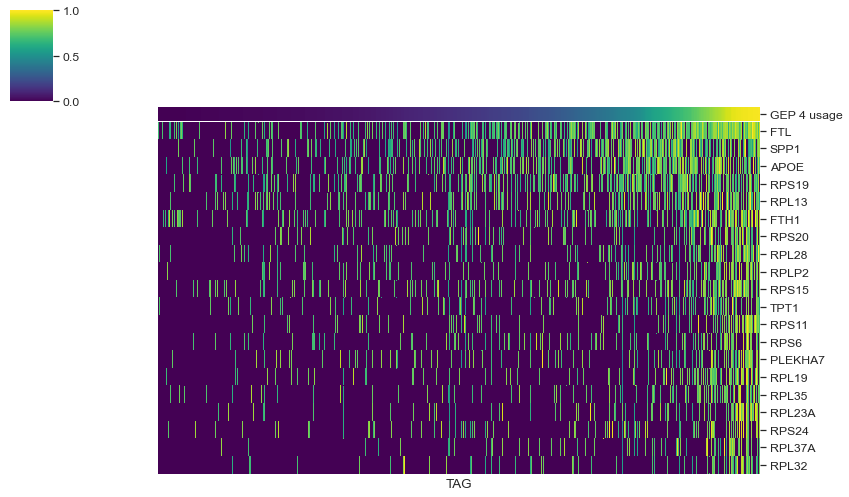

In [70]:
# GEP 4
cmap = sns.color_palette("viridis", as_cmap=True)
col_colors = exp_beta.iloc[:,20].map(cmap)

# Order gene by the area under curve (y: expression, x: cell usage)
auc = np.array([np.trapz(y=exp_beta[g].values, x=exp_beta['GEP %d usage' % gep_num].values) for g in gene_list])
order = auc.argsort()[::-1]

sns.clustermap(exp_beta.iloc[:,:20].transpose().iloc[order,:], xticklabels=False, figsize=(12,7),
               row_cluster=False, col_cluster=False, col_colors=col_colors, cmap=cmap)

# Enrichment analysis

In [5]:
import gseapy as gp

In [4]:
import pickle
dist = 'P'
rs = 3
K = 4
with open('/home/yw599/project/mathy_data/mathy_mic.deg.wu20.%s.rs%d.k%s.nb_naive.True.pkl' % (dist, rs, K), 'rb') as f:
    deg = pickle.load(f)

In [6]:
adata = sc.read_h5ad('/ysm-gpfs/pi/zhao/yw599/jupyter/ROSMAP_data/Mathy2019/mic.h5ad')

In [18]:
keys = list(deg.keys())
re_1 = deg[keys[0]]
re_1 = re_1.sort_values(by='z.score', ascending=False)
re_2 = deg[keys[1]]
re_2 = re_2.sort_values(by='z.score', ascending=False)
re_3 = deg[keys[2]]
re_3 = re_3.sort_values(by='z.score', ascending=False)
re_4 = deg[keys[3]]
re_4 = re_4.sort_values(by='z.score', ascending=False)

In [8]:
# Only perform DE test for highly variable genes

# Background genes
bg_gene = adata.var.index.tolist()

# Ordered gene list
glist = re_1.gene.tolist()

# Number of significantly positive genes
n_gene = np.sum((re_1['z.score']>0) & (re_1['p.val.adj']<0.05))
print(n_gene)

# Enrichr using GO BP
enr_1 = gp.enrichr(gene_list=glist[:n_gene],
                   gene_sets='../MSigDB/c5.go.bp.v7.4.symbols.gmt',
                   organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                   background=bg_gene,
                   description='test_name',
                   outdir='gseapy/mathy_mic/gep_1/enrichr_go_bp',
                   no_plot=True,
                   cutoff=0.05,
                   verbose=True
                   )

# Enrichr using REACTOME
enr_1_ = gp.enrichr(gene_list=glist[:n_gene],
                   gene_sets='../MSigDB/c2.cp.reactome.v7.4.symbols.gmt',
                   organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                   background=bg_gene,
                   description='test_name',
                   outdir='gseapy/mathy_mic/gep_1/enrichr_reactome',
                   no_plot=True,
                   cutoff=0.05,
                   verbose=True
                   )

2021-09-10 16:15:15,427 User Defined gene sets is given: ../MSigDB/c5.go.bp.v7.4.symbols.gmt
2021-09-10 16:15:15,575 Connecting to Enrichr Server to get latest library names


54


2021-09-10 16:15:16,044 Save file of enrichment results: Job Id:47410800022584
2021-09-10 16:15:16,083 Done.

2021-09-10 16:15:16,099 User Defined gene sets is given: ../MSigDB/c2.cp.reactome.v7.4.symbols.gmt
2021-09-10 16:15:16,134 Connecting to Enrichr Server to get latest library names
2021-09-10 16:15:16,186 Save file of enrichment results: Job Id:47410800023232
2021-09-10 16:15:16,193 Done.



In [9]:
enr_1.res2d.sort_values(by='Adjusted P-value').head(10)

Gene_set                                               Term  \
970  CUSTOM47410800022584                               GOBP_TORC1_SIGNALING   
429  CUSTOM47410800022584  GOBP_NEGATIVE_REGULATION_OF_CELL_ADHESION_MEDI...   
173  CUSTOM47410800022584         GOBP_CORNEA_DEVELOPMENT_IN_CAMERA_TYPE_EYE   
376  CUSTOM47410800022584                     GOBP_METENCEPHALON_DEVELOPMENT   
796  CUSTOM47410800022584   GOBP_REGULATION_OF_LONG_TERM_SYNAPTIC_DEPRESSION   
193  CUSTOM47410800022584                                GOBP_DENTINOGENESIS   
192  CUSTOM47410800022584                       GOBP_DENDRITE_SELF_AVOIDANCE   
595  CUSTOM47410800022584            GOBP_POSITIVE_REGULATION_OF_COAGULATION   
787  CUSTOM47410800022584              GOBP_REGULATION_OF_KIDNEY_DEVELOPMENT   
606  CUSTOM47410800022584  GOBP_POSITIVE_REGULATION_OF_HAIR_FOLLICLE_DEVE...   

    Overlap   P-value  Adjusted P-value           Genes  
970     2/2  0.000716          0.360434  GPR137C;CARD11  
429     2/2  0.000716          0.360434  SERPINE1;PDE3B  
173     1/1  0.027000          0.419196           WNT2B  
376    2/13  0.046142          0.419196       CKB;GRID2  
796     1/1  0.027000          0.419196           GRID2  
193     1/2  0.053284          0.419196        SERPINE1  
192     1/1  0.027000          0.419196           DSCAM  
595     2/7  0.013778          0.419196   SERPINE1;HPSE  
787     2/5  0.006793          0.419196     BASP1;WNT2B  
606     1/2  0.053284          0.419196            HPSE

In [10]:
enr_1_.res2d.sort_values(by='Adjusted P-value').head(10)

Gene_set                                               Term  \
99  CUSTOM47410800023232     REACTOME_WNT_LIGAND_BIOGENESIS_AND_TRAFFICKING   
47  CUSTOM47410800023232                        REACTOME_NETRIN_1_SIGNALING   
65  CUSTOM47410800023232                         REACTOME_RHOF_GTPASE_CYCLE   
63  CUSTOM47410800023232     REACTOME_REGULATION_OF_PTEN_GENE_TRANSCRIPTION   
59  CUSTOM47410800023232  REACTOME_PRESYNAPTIC_DEPOLARIZATION_AND_CALCIU...   
87  CUSTOM47410800023232  REACTOME_SUMOYLATION_OF_CHROMATIN_ORGANIZATION...   
30  CUSTOM47410800023232              REACTOME_GLYCOSAMINOGLYCAN_METABOLISM   
92  CUSTOM47410800023232             REACTOME_SYNTHESIS_OF_DIPHTHAMIDE_EEF2   
56  CUSTOM47410800023232             REACTOME_PLASMA_LIPOPROTEIN_REMODELING   
67  CUSTOM47410800023232  REACTOME_RNA_POLYMERASE_II_TRANSCRIBES_SNRNA_G...   

   Overlap   P-value  Adjusted P-value           Genes  
99     1/4  0.103779          0.312257           WNT2B  
47    2/11  0.033674          0.312257     DSCAM;TRPC1  
65     1/4  0.103779          0.312257           BASP1  
63     1/5  0.128025          0.312257           SCMH1  
59     1/4  0.103779          0.312257         CACNA1A  
87     1/3  0.078871          0.312257           SCMH1  
30    3/27  0.034438          0.312257  CHSY3;UST;HPSE  
92     1/2  0.053284          0.312257            DPH6  
56     1/5  0.128025          0.312257            LIPC  
67     1/2  0.053284          0.312257            ELL2

In [19]:
# Only perform DE test for highly variable genes

# Background genes
bg_gene = adata.var.index.tolist()

# Ordered gene list
glist = re_2.gene.tolist()

# Number of significantly positive genes
n_gene = np.sum((re_2['z.score']>0) & (re_2['p.val.adj']<0.05))
print(n_gene)

# Enrichr using GO BP
enr_2 = gp.enrichr(gene_list=glist[:n_gene],
                   gene_sets='../MSigDB/c5.go.bp.v7.4.symbols.gmt',
                   organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                   background=bg_gene,
                   description='test_name',
                   outdir='gseapy/mathy_mic/gep_2/enrichr_go_bp',
                   no_plot=True,
                   cutoff=0.05,
                   verbose=True
                   )

# Enrichr using REACTOME
enr_2_ = gp.enrichr(gene_list=glist[:n_gene],
                   gene_sets='../MSigDB/c2.cp.reactome.v7.4.symbols.gmt',
                   organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                   background=bg_gene,
                   description='test_name',
                   outdir='gseapy/mathy_mic/gep_2/enrichr_reactome',
                   no_plot=True,
                   cutoff=0.05,
                   verbose=True
                   )

2021-09-10 16:32:08,438 User Defined gene sets is given: ../MSigDB/c5.go.bp.v7.4.symbols.gmt
2021-09-10 16:32:08,550 Connecting to Enrichr Server to get latest library names


113


2021-09-10 16:32:09,444 Save file of enrichment results: Job Id:47410856411000
2021-09-10 16:32:09,467 Done.

2021-09-10 16:32:09,486 User Defined gene sets is given: ../MSigDB/c2.cp.reactome.v7.4.symbols.gmt
2021-09-10 16:32:09,503 Connecting to Enrichr Server to get latest library names
2021-09-10 16:32:09,650 Save file of enrichment results: Job Id:47410799524168
2021-09-10 16:32:09,660 Done.



In [20]:
enr_2.res2d.sort_values(by='Adjusted P-value').head(10)

Gene_set                                               Term  \
2053  CUSTOM47410856411000    GOBP_REGULATION_OF_PHOSPHORUS_METABOLIC_PROCESS   
2080  CUSTOM47410856411000         GOBP_REGULATION_OF_PROTEIN_PHOSPHORYLATION   
2078  CUSTOM47410856411000    GOBP_REGULATION_OF_PROTEIN_MODIFICATION_PROCESS   
64    CUSTOM47410856411000  GOBP_ANATOMICAL_STRUCTURE_FORMATION_INVOLVED_I...   
1715  CUSTOM47410856411000                 GOBP_RECEPTOR_MEDIATED_ENDOCYTOSIS   
475   CUSTOM47410856411000                   GOBP_ENDOTHELIAL_CELL_CHEMOTAXIS   
1549  CUSTOM47410856411000  GOBP_POSITIVE_REGULATION_OF_PHOSPHORUS_METABOL...   
1673  CUSTOM47410856411000                       GOBP_PROTEIN_PHOSPHORYLATION   
1363  CUSTOM47410856411000     GOBP_POSITIVE_REGULATION_OF_CATALYTIC_ACTIVITY   
1505  CUSTOM47410856411000     GOBP_POSITIVE_REGULATION_OF_MOLECULAR_FUNCTION   

     Overlap       P-value  Adjusted P-value  \
2053  28/194  1.142417e-06          0.001271   
2080  24/152  1.521848e-06          0.001271   
2078  28/189  6.526610e-07          0.001271   
64    22/134  2.296612e-06          0.001438   
1715   12/45  3.507032e-06          0.001464   
475      5/6  3.030854e-06          0.001464   
1549  21/130  5.338152e-06          0.001910   
1673  27/199  6.490783e-06          0.002032   
1363  25/180  1.015965e-05          0.002828   
1505  28/223  1.965440e-05          0.004923   

                                                  Genes  
2053  PARD3;VAV3;GADD45B;MAP3K8;THBS1;DUSP1;ACSL1;PI...  
2080  PARD3;GADD45B;MAP3K8;THBS1;DUSP1;ACSL1;PID1;CD...  
2078  PARD3;GADD45B;MAP3K8;THBS1;DUSP1;ACSL1;PID1;CD...  
64    VAV3;RHOB;EPB41L3;THBS1;DUSP1;PMP22;TGFBI;CD36...  
1715  MRC1;MSR1;MARCO;HSP90AA1;FCGR2B;CD163;SIGLEC1;...  
475                         NRP1;NR4A1;LGMN;THBS1;HSPB1  
1549  VAV3;GADD45B;MAP3K8;THBS1;ACSL1;PID1;CD36;NRP1...  
1673  PARD3;DAPK1;GADD45B;TEX14;MAP3K8;THBS1;DUSP1;A...  
1363  DAPK1;VAV3;RGS1;GADD45B;MAP3K8;LGMN;THBS1;ACSL...  
1505  DAPK1;VAV3;RGS1;GADD45B;MAP3K8;LGMN;THBS1;ACSL...

In [21]:
enr_2_.res2d.sort_values(by='Adjusted P-value').head(10)

Gene_set                                               Term  \
34   CUSTOM47410799524168                        REACTOME_CDC42_GTPASE_CYCLE   
290  CUSTOM47410799524168                          REACTOME_RHO_GTPASE_CYCLE   
24   CUSTOM47410799524168  REACTOME_BINDING_AND_UPTAKE_OF_LIGANDS_BY_SCAV...   
239  CUSTOM47410799524168  REACTOME_PLATELET_ACTIVATION_SIGNALING_AND_AGG...   
134  CUSTOM47410799524168           REACTOME_G_ALPHA_12_13_SIGNALLING_EVENTS   
278  CUSTOM47410799524168                         REACTOME_RHOG_GTPASE_CYCLE   
271  CUSTOM47410799524168  REACTOME_RESPONSE_TO_ELEVATED_PLATELET_CYTOSOL...   
335  CUSTOM47410799524168  REACTOME_SIGNALING_BY_RHO_GTPASES_MIRO_GTPASES...   
117  CUSTOM47410799524168          REACTOME_EXTRA_NUCLEAR_ESTROGEN_SIGNALING   
113  CUSTOM47410799524168                    REACTOME_ESR_MEDIATED_SIGNALING   

    Overlap   P-value  Adjusted P-value  \
34     7/17  0.000019          0.004564   
290   11/47  0.000036          0.004564   
24     6/13  0.000035          0.004564   
239    8/31  0.000214          0.020528   
134     4/9  0.000977          0.054895   
278     4/9  0.000977          0.054895   
271    5/15  0.001003          0.054895   
335   11/70  0.001464          0.066286   
117    4/10  0.001558          0.066286   
113    5/17  0.001887          0.072270   

                                                 Genes  
34          IQGAP2;TFRC;CPNE8;VAV3;ITSN1;STARD13;GNA13  
290  HSP90AA1;IQGAP2;PEAK1;CPNE8;TFRC;VAV3;ITSN1;ST...  
24              MARCO;MSR1;HSP90AA1;CD163;COLEC12;CD36  
239          TTN;VAV3;SRGN;CD36;RHOB;F13A1;THBS1;GNA13  
134                              RHOB;VAV3;ITSN1;GNA13  
278                             TFRC;ITSN1;IQGAP2;VAV3  
271                          TTN;SRGN;CD36;F13A1;THBS1  
335  HSP90AA1;IQGAP2;PEAK1;CPNE8;TFRC;VAV3;ITSN1;ST...  
117                           HSP90AA1;FOS;HBEGF;HSPB1  
113                       HSP90AA1;JUN;FOS;HBEGF;HSPB1

In [22]:
# Only perform DE test for highly variable genes

# Background genes
bg_gene = adata.var.index.tolist()

# Ordered gene list
glist = re_3.gene.tolist()

# Number of significantly positive genes
n_gene = np.sum((re_3['z.score']>0) & (re_3['p.val.adj']<0.05))
print(n_gene)

# Enrichr using GO BP
enr_3 = gp.enrichr(gene_list=glist[:n_gene],
                   gene_sets='../MSigDB/c5.go.bp.v7.4.symbols.gmt',
                   organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                   background=bg_gene,
                   description='test_name',
                   outdir='gseapy/mathy_mic/gep_3/enrichr_go_bp',
                   no_plot=True,
                   cutoff=0.05,
                   verbose=True
                   )

# Enrichr using REACTOME
enr_3_ = gp.enrichr(gene_list=glist[:n_gene],
                   gene_sets='../MSigDB/c2.cp.reactome.v7.4.symbols.gmt',
                   organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                   background=bg_gene,
                   description='test_name',
                   outdir='gseapy/mathy_mic/gep_3/enrichr_reactome',
                   no_plot=True,
                   cutoff=0.05,
                   verbose=True
                   )

2021-09-10 16:32:48,430 User Defined gene sets is given: ../MSigDB/c5.go.bp.v7.4.symbols.gmt
2021-09-10 16:32:48,543 Connecting to Enrichr Server to get latest library names


193


2021-09-10 16:32:49,458 Save file of enrichment results: Job Id:47410856489752
2021-09-10 16:32:49,485 Done.

2021-09-10 16:32:49,505 User Defined gene sets is given: ../MSigDB/c2.cp.reactome.v7.4.symbols.gmt
2021-09-10 16:32:49,524 Connecting to Enrichr Server to get latest library names
2021-09-10 16:32:49,716 Save file of enrichment results: Job Id:47410812226008
2021-09-10 16:32:49,726 Done.



In [23]:
enr_3.res2d.sort_values(by='Adjusted P-value').head(10)

Gene_set                                               Term  \
1945  CUSTOM47410856489752           GOBP_REGULATION_OF_IMMUNE_SYSTEM_PROCESS   
244   CUSTOM47410856489752                               GOBP_CELL_ACTIVATION   
727   CUSTOM47410856489752                         GOBP_LYMPHOCYTE_ACTIVATION   
29    CUSTOM47410856489752                      GOBP_ADAPTIVE_IMMUNE_RESPONSE   
1944  CUSTOM47410856489752                 GOBP_REGULATION_OF_IMMUNE_RESPONSE   
2471  CUSTOM47410856489752                             GOBP_T_CELL_ACTIVATION   
1428  CUSTOM47410856489752  GOBP_POSITIVE_REGULATION_OF_IMMUNE_SYSTEM_PROCESS   
1427  CUSTOM47410856489752        GOBP_POSITIVE_REGULATION_OF_IMMUNE_RESPONSE   
2480  CUSTOM47410856489752                  GOBP_T_CELL_MEDIATED_CYTOTOXICITY   
367   CUSTOM47410856489752            GOBP_DEFENSE_RESPONSE_TO_OTHER_ORGANISM   

     Overlap       P-value  Adjusted P-value  \
1945  56/213  4.044868e-14      1.025779e-10   
244   56/220  1.895632e-13      2.403662e-10   
727   38/121  3.323956e-12      2.809851e-09   
29     28/70  4.495236e-12      2.849980e-09   
1944  38/125  1.037450e-11      5.261944e-09   
2471  33/100  2.430940e-11      1.027477e-08   
1428  38/146  1.777445e-09      6.439428e-07   
1427   28/90  4.465249e-09      1.415484e-06   
2480    9/10  5.605788e-09      1.425395e-06   
367   39/158  5.620641e-09      1.425395e-06   

                                                  Genes  
1945  CST7;PYHIN1;KAT2B;RASGRP1;PTPN22;YES1;CAMK4;TX...  
244   RASGRP1;PTPN22;YES1;PLAC8;CAMK4;GNG2;TXK;RAB27...  
727   RASGRP1;PTPN22;YES1;CAMK4;RAB27A;VAV3;CD8A;IRF...  
29    CAMK4;TXK;RAB27A;CD8A;IRF1;HLA-A;SH2D1B;PRF1;H...  
1944  PYHIN1;RASGRP1;PTPN22;YES1;TXK;VAV3;CD8A;IRF1;...  
2471  RASGRP1;PTPN22;YES1;CAMK4;RAB27A;CD8A;IRF1;LCK...  
1428  PYHIN1;RASGRP1;PTPN22;YES1;TXK;VAV3;LEF1;LCK;H...  
1427  PYHIN1;RASGRP1;PTPN22;YES1;TXK;VAV3;LCK;HLA-A;...  
2480  GZMM;RAB27A;KLRD1;B2M;IL7R;HLA-A;KLRC1;HLA-B;PRF1  
367   PYHIN1;RASGRP1;PTPN22;YES1;TXK;RAB27A;IRF1;LCK...

In [24]:
enr_3_.res2d.sort_values(by='Adjusted P-value').head(10)

Gene_set                                               Term  \
215  CUSTOM47410812226008                      REACTOME_INNATE_IMMUNE_SYSTEM   
209  CUSTOM47410812226008  REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN...   
99   CUSTOM47410812226008                        REACTOME_DAP12_INTERACTIONS   
8    CUSTOM47410812226008                    REACTOME_ADAPTIVE_IMMUNE_SYSTEM   
415  CUSTOM47410812226008                          REACTOME_RHO_GTPASE_CYCLE   
100  CUSTOM47410812226008                           REACTOME_DAP12_SIGNALING   
94   CUSTOM47410812226008       REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM   
223  CUSTOM47410812226008                REACTOME_INTERFERON_GAMMA_SIGNALING   
340  CUSTOM47410812226008  REACTOME_PLATELET_ACTIVATION_SIGNALING_AND_AGG...   
473  CUSTOM47410812226008  REACTOME_SIGNALING_BY_RHO_GTPASES_MIRO_GTPASES...   

    Overlap       P-value  Adjusted P-value  \
215  33/124  1.376003e-08          0.000007   
209   14/30  1.397431e-07          0.000038   
99     8/11  8.390259e-07          0.000151   
8    26/106  3.217278e-06          0.000348   
415   16/47  3.126652e-06          0.000348   
100     6/7  4.842280e-06          0.000437   
94   24/102  1.732030e-05          0.001339   
223    7/13  7.270750e-05          0.003801   
340   11/31  7.661128e-05          0.003801   
473   18/70  6.067907e-05          0.003801   

                                                 Genes  
215  RASGRP1;YES1;PLAC8;ATP8A1;TXK;RAB27A;VAV3;LCK;...  
209  CD96;HLA-C;KLRD1;CD247;KLRB1;CD8A;B2M;ITGA4;KL...  
99            FYN;HLA-C;KLRD1;VAV3;B2M;LCK;GRAP2;HLA-B  
8    RASGRP1;PTPN22;YES1;CD8A;LCK;HLA-A;SH2D1B;KLRF...  
415  MPP7;IQGAP2;FNBP1;RRAS2;ACTG1;VAV3;RHOH;ARHGEF...  
100                       FYN;KLRD1;VAV3;B2M;LCK;GRAP2  
94   YES1;LTB;IRF1;LCK;VIM;NCAM1;FLNA;ISG15;HLA-A;C...  
223              HLA-C;B2M;IRF1;NCAM1;HLA-A;HLA-B;CD44  
340  RASGRP1;FYN;GNG2;RAB27B;VAV3;TUBA4A;LCK;FLNA;P...  
473  MPP7;IQGAP2;FNBP1;RRAS2;ACTG1;VAV3;RHOH;ARHGEF...

In [25]:
# Only perform DE test for highly variable genes

# Background genes
bg_gene = adata.var.index.tolist()

# Ordered gene list
glist = re_4.gene.tolist()

# Number of significantly positive genes
n_gene = np.sum((re_4['z.score']>0) & (re_4['p.val.adj']<0.05))
print(n_gene)

# Enrichr using GO BP
enr_4 = gp.enrichr(gene_list=glist[:n_gene],
                   gene_sets='../MSigDB/c5.go.bp.v7.4.symbols.gmt',
                   organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                   background=bg_gene,
                   description='test_name',
                   outdir='gseapy/mathy_mic/gep_4/enrichr_go_bp',
                   no_plot=True,
                   cutoff=0.05,
                   verbose=True
                   )

# Enrichr using REACTOME
enr_4_ = gp.enrichr(gene_list=glist[:n_gene],
                   gene_sets='../MSigDB/c2.cp.reactome.v7.4.symbols.gmt',
                   organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                   background=bg_gene,
                   description='test_name',
                   outdir='gseapy/mathy_mic/gep_4/enrichr_reactome',
                   no_plot=True,
                   cutoff=0.05,
                   verbose=True
                   )

2021-09-10 16:32:55,078 User Defined gene sets is given: ../MSigDB/c5.go.bp.v7.4.symbols.gmt
2021-09-10 16:32:55,192 Connecting to Enrichr Server to get latest library names


43


2021-09-10 16:32:55,722 Save file of enrichment results: Job Id:47410840789496
2021-09-10 16:32:55,739 Done.

2021-09-10 16:32:55,758 User Defined gene sets is given: ../MSigDB/c2.cp.reactome.v7.4.symbols.gmt
2021-09-10 16:32:55,776 Connecting to Enrichr Server to get latest library names
2021-09-10 16:32:55,927 Save file of enrichment results: Job Id:47410856127872
2021-09-10 16:32:55,938 Done.



In [36]:
?gp.enrichr

In [26]:
enr_4.res2d.sort_values(by='Adjusted P-value').head(10)

Gene_set                                               Term  \
195   CUSTOM47410840789496  GOBP_COTRANSLATIONAL_PROTEIN_TARGETING_TO_MEMB...   
644   CUSTOM47410840789496  GOBP_NUCLEAR_TRANSCRIBED_MRNA_CATABOLIC_PROCES...   
261   CUSTOM47410840789496  GOBP_ESTABLISHMENT_OF_PROTEIN_LOCALIZATION_TO_...   
643   CUSTOM47410840789496    GOBP_NUCLEAR_TRANSCRIBED_MRNA_CATABOLIC_PROCESS   
881   CUSTOM47410840789496  GOBP_PROTEIN_LOCALIZATION_TO_ENDOPLASMIC_RETIC...   
1313  CUSTOM47410840789496                      GOBP_TRANSLATIONAL_INITIATION   
1345  CUSTOM47410840789496                         GOBP_VIRAL_GENE_EXPRESSION   
1251  CUSTOM47410840789496                         GOBP_RNA_CATABOLIC_PROCESS   
669   CUSTOM47410840789496     GOBP_ORGANIC_CYCLIC_COMPOUND_CATABOLIC_PROCESS   
896   CUSTOM47410840789496                 GOBP_PROTEIN_TARGETING_TO_MEMBRANE   

     Overlap       P-value  Adjusted P-value  \
195    21/22  6.198652e-37      8.392975e-34   
644    21/23  7.052772e-36      4.774727e-33   
261    21/25  3.451858e-34      1.557938e-31   
643    21/27  7.906480e-33      2.676344e-30   
881    21/30  3.700713e-31      1.002153e-28   
1313   21/31  1.134997e-30      2.561309e-28   
1345   21/34  2.299586e-29      4.448056e-27   
1251   23/47  4.283993e-29      7.250658e-27   
669    25/68  5.903267e-28      8.881137e-26   
896    21/41  6.185799e-27      8.375571e-25   

                                                  Genes  
195   RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
644   RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
261   RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
643   RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
881   RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
1313  RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
1345  RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
1251  RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
669   RPL27A;RPL35;RPS24;SPP1;RPL32;RPS19;RPLP2;RPL2...  
896   RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...

In [27]:
enr_4_.res2d.sort_values(by='Adjusted P-value').head(10)

Gene_set                                               Term  \
361  CUSTOM47410856127872  REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN...   
291  CUSTOM47410856127872  REACTOME_RESPONSE_OF_EIF2AK4_GCN2_TO_AMINO_ACI...   
157  CUSTOM47410856127872                       REACTOME_INFLUENZA_INFECTION   
222  CUSTOM47410856127872               REACTOME_NONSENSE_MEDIATED_DECAY_NMD   
40   CUSTOM47410856127872           REACTOME_CELLULAR_RESPONSE_TO_STARVATION   
112  CUSTOM47410856127872         REACTOME_EUKARYOTIC_TRANSLATION_ELONGATION   
316  CUSTOM47410856127872               REACTOME_SELENOAMINO_ACID_METABOLISM   
113  CUSTOM47410856127872         REACTOME_EUKARYOTIC_TRANSLATION_INITIATION   
271  CUSTOM47410856127872  REACTOME_REGULATION_OF_EXPRESSION_OF_SLITS_AND...   
307  CUSTOM47410856127872                           REACTOME_RRNA_PROCESSING   

    Overlap       P-value  Adjusted P-value  \
361   21/22  6.198652e-37      9.721568e-35   
291   21/22  6.198652e-37      9.721568e-35   
157   22/25  7.061672e-37      9.721568e-35   
222   21/23  7.052772e-36      4.854658e-34   
40    21/23  7.052772e-36      4.854658e-34   
112   21/23  7.052772e-36      4.854658e-34   
316   21/24  5.582291e-35      3.293551e-33   
113   21/25  3.451858e-34      1.782022e-32   
271   21/28  3.128939e-32      1.435836e-30   
307   21/32  3.266609e-30      1.349110e-28   

                                                 Genes  
361  RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
291  RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
157  RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
222  RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
40   RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
112  RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
316  RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
113  RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
271  RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...  
307  RPL27A;RPL35;RPS24;RPL32;RPS19;RPLP2;RPL28;RPL...

In [84]:
from os import listdir
from some_functions import dotplot

In [85]:
for gep in [1,2,3,4]:
    gmt = '../MSigDB/c2.cp.reactome.v7.4.symbols.gmt' 
    resfolder = 'gseapy/mathy_mic/gep_%d/enrichr_reactome/'%gep
    resfile = [file for file in listdir(resfolder) if file.endswith('.txt')][0]
    respath = resfolder+resfile
    db = 'REACTOME'
    #savefile = respath[:-3] + 'xlsx'
    savefile = False
    saveplot = 'figures/mathy_mic/gep_%d.reactome.pdf'%gep
    dotplot(pd.read_csv(respath, sep='\t'), db, gmt, go=False, savefile=savefile, saveplot=saveplot)

/gpfs/ysm/home/yw599/venv/lib64/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/gibbs/pi/zhao/yw599/scAAnet/scAAnet_latest/some_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Term'].iloc[i] = convertTermREACTOME(df['Term'].iloc[i], gmt)


In [76]:
for gep in [1,2,3,4]:
    gmt = '../MSigDB/c5.go.bp.v7.4.symbols.gmt' 
    resfolder = 'gseapy/mathy_mic/gep_%d/enrichr_go_bp/'%gep
    resfile = [file for file in listdir(resfolder) if file.endswith('.txt')][0]
    respath = resfolder+resfile
    db = 'GO biological process'
    #savefile = respath[:-3] + 'xlsx'
    savefile=False
    saveplot = 'figures/mathy_mic/gep_%d.go.bp.pdf'%gep
    dotplot(pd.read_csv(respath, sep='\t'), db, gmt, savefile=savefile, saveplot=saveplot)

/gpfs/ysm/home/yw599/venv/lib64/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/gibbs/pi/zhao/yw599/scAAnet/scAAnet_latest/some_functions.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Term'].iloc[i] = convertTermGO(df['Term'].iloc[i], gmt)
